# CRUST1 Moho Model from Uieda et al. 2017.

Here we attempt to reproduce the CRUST1 Moho inversion for South America from [Uieda et al. 2017:](https://doi.org/10.1093/gji/ggw390) Fast nonlinear gravity inversion in spherical coordinates with application to the South American Moho. This is a semi-synthetic model, where true Moho topography data from CRUST1 is used to forward model the observed gravity. This synthetic gravity data is then used to invert for Moho topography. We start by following their approach, but using Invert4Geom. We follow this by using our own approach of incorporating a starting model and adhering to points of known Moho elevation.

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging
import pathlib
import pickle

import numpy as np
import pandas as pd
import pooch
import pyproj
import verde as vd
import xarray as xr
from polartoolkit import fetch, maps
from polartoolkit import utils as polar_utils

from invert4geom import (
    cross_validation,
    inversion,
    optimization,
    plotting,
    regional,
    synthetic,
    utils,
)

# set up logging to see what's going on
logging.basicConfig(level=logging.INFO)

# Get datasets

Here we use `Pooch` to download the CRUST1 global Moho topography dataset, and the locations of seismic measurements of Moho depth for South America. We perform some preprocessing on these datasets, subsetting them to match the geographic extent used in the paper. We convert the data to projected coordinates, instead of the geographic coordinates used in the paper.

In [2]:
url = "https://igppweb.ucsd.edu/~gabi/crust1/depthtomoho.xyz.zip"
known_hash = "36089a537ed45795557999003d0eada9935f1cc589a6ddb486a7eac716dc7ff2"
path = pooch.retrieve(
    url=url,
    path=pooch.os_cache("invert4geom"),
    known_hash=known_hash,
    progressbar=True,
    processor=pooch.Unzip(),
)[0]

df = pd.read_csv(path, header=None, sep=r"\s+", names=["lon", "lat", "upward"])

# turn elevation to meters
df["upward"] = df.upward * 1000

# turn into grid
true_moho = df.set_index(["lat", "lon"]).to_xarray().rio.write_crs("EPSG:4326").upward

# subset to south america with buffer
region_ll = (-92, -28, -62, 22)
true_moho = true_moho.sel(
    lon=slice(region_ll[0], region_ll[1]),
    lat=slice(region_ll[2], region_ll[3]),
).drop_vars("spatial_ref")

shape = (80, 60)  # n, e

# We're choosing the latitude of true scale as the mean latitude of our dataset
projection = pyproj.Proj(proj="merc", lat_ts=df.lat.mean())

region_ll = (-90, -30, -60, 20)
region = vd.project_region(region_ll, projection)

true_moho = vd.project_grid(
    true_moho,
    projection,
    # spacing=10e3,
    # adjust="region",
    # spacing=spacing,
    # region=region,
)

coords = vd.grid_coordinates(
    region=region,
    shape=shape,
    # spacing=spacing,
    # adjust="region",
)
grid = vd.make_xarray_grid(coords, np.ones_like(coords[0]), data_names="z").z
grid = grid.rio.set_spatial_dims("easting", "northing").rio.write_crs("epsg:4326")
true_moho = (
    true_moho.rio.set_spatial_dims("easting", "northing")
    .rio.write_crs("epsg:4326")
    .rio.write_nodata(np.nan)
)
true_moho = (
    true_moho.rio.reproject_match(grid)
    .rename({"x": "easting", "y": "northing"})
    .drop_vars("spatial_ref")
)

# recreate to drop metadata
df = true_moho.to_dataframe().reset_index()  # .astype({"easting":int,"northing":int})
true_moho = df.set_index(["northing", "easting"]).to_xarray().upward

width = region[1] - region[0]
height = region[3] - region[2]
x_mid = round(np.mean(region[:2]), -3)
y_mid = round(np.mean(region[2:]), -3)

spacing, _, _, _, _ = polar_utils.get_grid_info(true_moho)
spacing = round(spacing, -3)
region = (
    x_mid - (spacing * (shape[1] / 2)),
    x_mid + (spacing * (shape[1] / 2)),
    y_mid - (spacing * (shape[0] / 2)),
    y_mid + (spacing * (shape[0] / 2)),
)
true_moho = fetch.resample_grid(true_moho, spacing=spacing, region=region).rename(
    {"x": "easting", "y": "northing"}
)
true_moho

grdsample [WARNING]: Output sampling interval in x exceeds input interval and may lead to aliasing.


<xarray.DataArray 'z' (northing: 79, easting: 50)> Size: 16kB
array([[-11996.88 , -11993.936, -12004.855, ...,  -9651.419,  -9768.617,
         -9836.995],
       [-11996.603, -12003.306, -12016.786, ..., -10058.326, -10258.755,
        -10044.96 ],
       [-12034.696, -12027.714, -12032.665, ..., -10435.053, -10562.211,
        -10229.877],
       ...,
       [-26719.041, -24199.436, -22419.082, ..., -11974.452, -11935.457,
        -11905.756],
       [-25076.738, -22405.977, -19385.184, ..., -11980.165, -11887.041,
        -11716.937],
       [-25066.1  , -22412.135, -17921.285, ..., -12015.668, -11958.471,
        -11759.952]], dtype=float32)
Coordinates:
  * northing  (northing) float64 632B -8.308e+06 -8.174e+06 ... 2.144e+06
  * easting   (easting) float64 400B -9.916e+06 -9.782e+06 ... -3.35e+06
Attributes:
    Conventions:   CF-1.7
    title:         
    history:       gmt grdsample @GMTAPI@-S-I-G-M-G-N-000000 -G@GMTAPI@-S-O-G...
    description:   
    actual_range:  [-68726.5         -8954.62792969]
    long_name:     z

In [3]:
spacing, region, _, _, _ = polar_utils.get_grid_info(true_moho)
spacing, region

(134000.0, (-9916000.0, -3350000.0, -8308000.0, 2144000.0))

In [4]:
url = "https://raw.githubusercontent.com/pinga-lab/paper-moho-inversion-tesseroids/master/data/crust1-point-depths.txt"
known_hash = "788426dbb100caf86b4973acf8e2b1964a2cfe517cb17c3ea9cd30ee99c9c6fb"
path = pooch.retrieve(
    url=url,
    path=pooch.os_cache("invert4geom"),
    known_hash=known_hash,
    progressbar=True,
)
df = pd.read_csv(path, skiprows=4, sep=" ", names=["lat", "lon", "upward"])

df = df.drop(columns="upward")

projection = pyproj.Proj(proj="merc", lat_ts=df.lat.mean())

proj_coords = projection(df.lon.values, df.lat.values)
df["easting"] = proj_coords[0]
df["northing"] = proj_coords[1]

df["inside"] = vd.inside(
    (df.easting, df.northing),
    region=region,
)
df = df[df.inside].drop(columns="inside")
df

lat      lon       easting      northing
0    -9.0387 -37.0454 -3.969459e+06 -9.660928e+05
1   -19.7393 -50.2331 -5.382537e+06 -2.144332e+06
2   -18.5471 -52.0251 -5.574552e+06 -2.009914e+06
3   -18.5081 -52.0740 -5.579791e+06 -2.005533e+06
4   -20.4760 -55.6990 -5.968215e+06 -2.227898e+06
..       ...      ...           ...           ...
932 -39.0000 -70.8000 -7.586305e+06 -4.518984e+06
933 -39.0000 -70.5000 -7.554159e+06 -4.518984e+06
934 -39.0000 -70.0000 -7.500584e+06 -4.518984e+06
935 -39.0000 -69.6000 -7.457723e+06 -4.518984e+06
936 -39.0000 -68.7000 -7.361287e+06 -4.518984e+06

[937 rows x 4 columns]

In [5]:
# sample grid values at points
constraint_points = utils.sample_grids(
    df,
    true_moho,
    "upward",
)
constraint_points.describe()

lat         lon       easting      northing        upward
count  937.000000  937.000000  9.370000e+02  9.370000e+02    937.000000
mean   -15.779085  -60.878246 -6.523177e+06 -1.747164e+06 -37889.681529
std     13.436299   12.894853  1.381699e+06  1.507106e+06  12374.364473
min    -54.140000  -86.300000 -9.247148e+06 -6.893881e+06 -66745.216910
25%    -25.700000  -70.346300 -7.537690e+06 -2.833232e+06 -44403.793162
50%    -17.360000  -66.780000 -7.155557e+06 -1.877012e+06 -39371.758409
75%     -7.639000  -47.794900 -5.121281e+06 -8.155003e+05 -30394.881848
max     13.949700  -35.104000 -3.761436e+06  1.499808e+06 -11424.326640

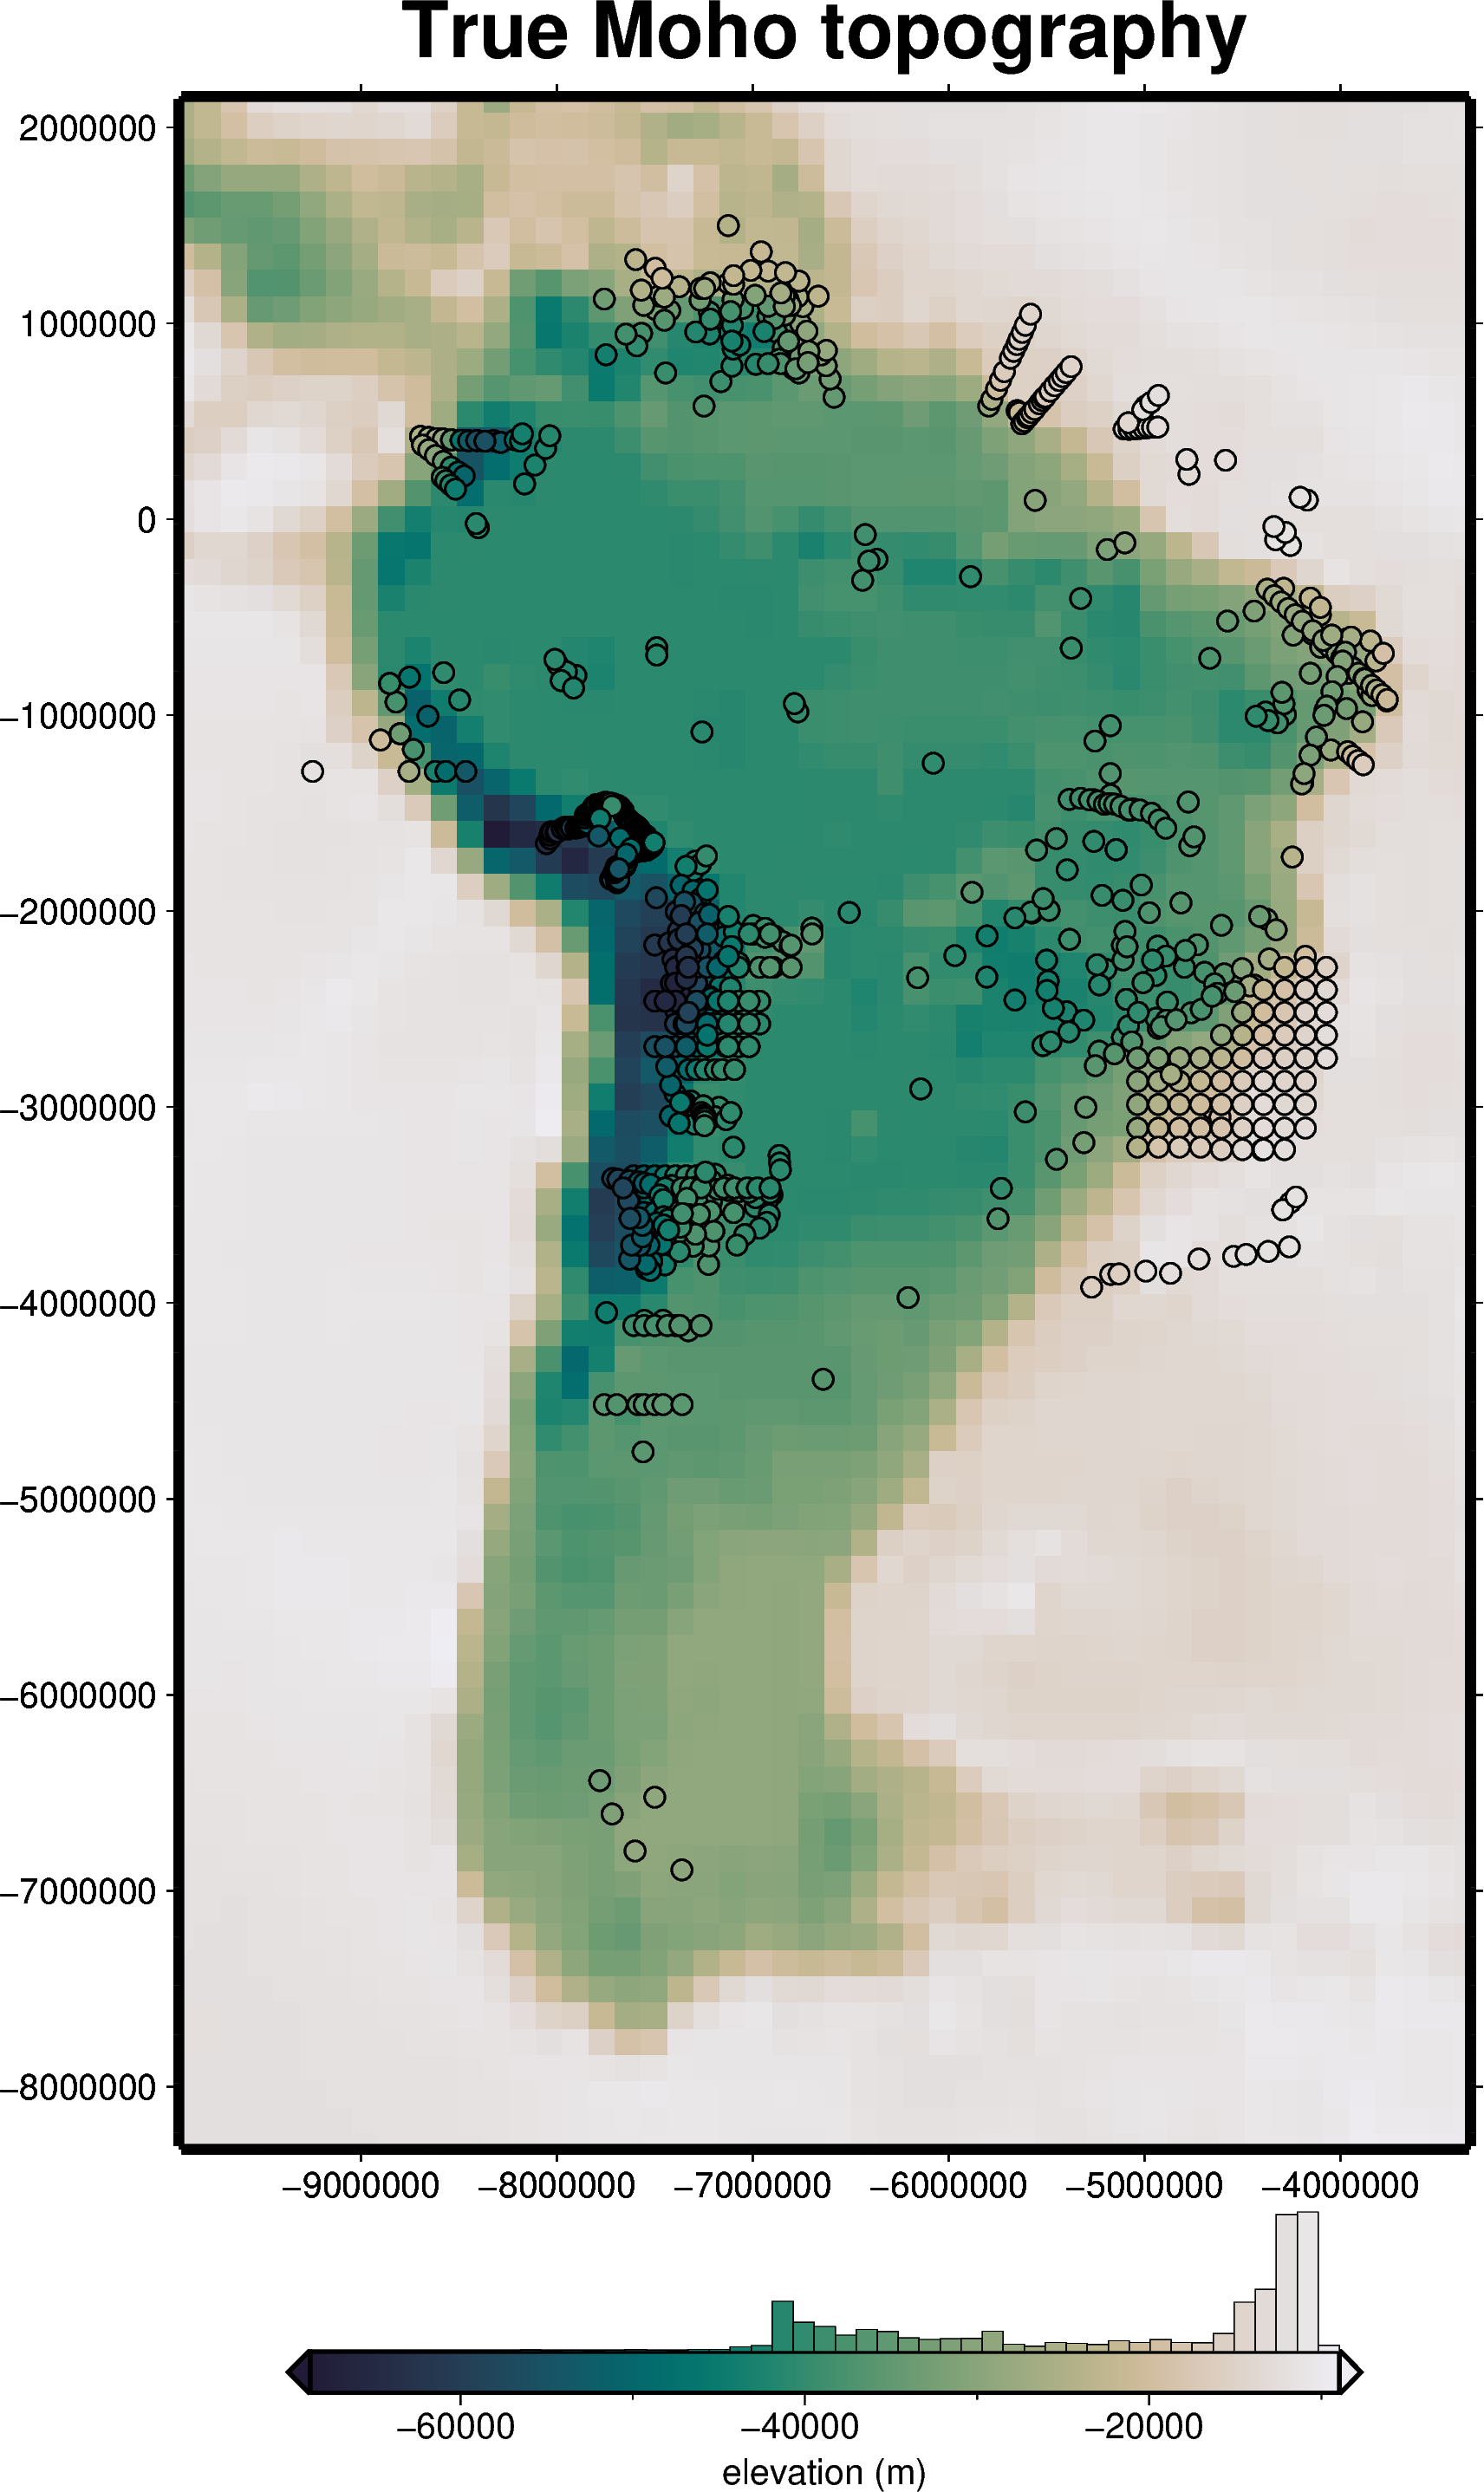

In [6]:
fig = maps.plot_grd(
    true_moho,
    fig_height=20,
    title="True Moho topography",
    hist=True,
    cmap="rain",
    reverse_cpt=True,
    cbar_yoffset=2,
    cbar_label="elevation (m)",
    # robust=True,
    frame=["nSWe", "xaf10000", "yaf10000"],
)
# plot seismic points
fig.plot(
    x=constraint_points.easting,
    y=constraint_points.northing,
    style="c.2c",
    fill=constraint_points.upward,
    cmap=True,
    pen=".6p,black",
)
fig.show()

# Observed gravity data
We can now forward-model the effects of this topography and add some noise to make a synthetic observed gravity dataset.

MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


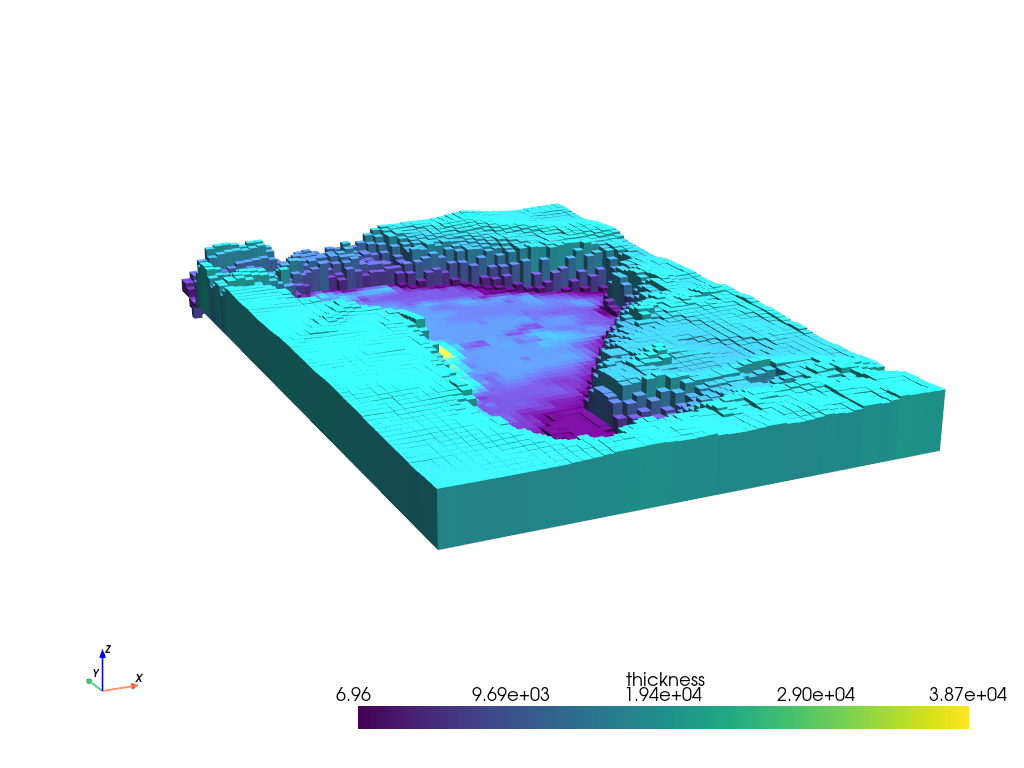

In [7]:
# Define the reference level (height in meters).
# This is the Moho depth of the Normal Earth
true_zref = -30e3

# The density contrast is negative if the relief is below the reference
true_density_contrast = 350
density_grid = xr.where(
    true_moho >= true_zref, true_density_contrast, -true_density_contrast
)

# make prism layer
prisms = utils.grids_to_prisms(true_moho, true_zref, density=density_grid)

plotting.show_prism_layers(
    prisms,
    color_by="thickness",
    # color_by="density",
    log_scale=False,
    zscale=40,
    backend="static",
)

In [8]:
# make pandas dataframe of locations to calculate gravity
# this represents the station locations of a gravity survey
# create lists of coordinates
coords = vd.grid_coordinates(
    region=region,
    spacing=spacing,
    pixel_register=False,
    extra_coords=50e3,  # survey elevation
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
).upward

grav_df = vd.grid_to_table(observations)

# resample to half spacing
grav_df_resampled = cross_validation.resample_with_test_points(spacing, grav_df, region)

grav_df_resampled["gravity_anomaly"] = prisms.prism_layer.gravity(
    coordinates=(
        grav_df_resampled.easting,
        grav_df_resampled.northing,
        grav_df_resampled.upward,
    ),
    field="g_z",
    progressbar=True,
)
# contaminate gravity with random noise
grav_df_resampled["gravity_anomaly"], stddev = synthetic.contaminate(
    grav_df_resampled.gravity_anomaly,
    stddev=5,
    percent=False,
    seed=0,
)

grav_df_resampled.describe()

  0%|          | 0/15543 [00:00<?, ?it/s]

INFO:invert4geom:Standard deviation used for noise: [5.0]


northing       easting   upward  gravity_anomaly
count  1.554300e+04  1.554300e+04  15543.0     15543.000000
mean  -3.082000e+06 -6.633000e+06  50000.0       101.243413
std    3.036610e+06  1.914746e+06      0.0       159.812794
min   -8.308000e+06 -9.916000e+06  50000.0      -370.518832
25%   -5.695000e+06 -8.308000e+06  50000.0       -52.404554
50%   -3.082000e+06 -6.633000e+06  50000.0       186.385180
75%   -4.690000e+05 -4.958000e+06  50000.0       238.595664
max    2.144000e+06 -3.350000e+06  50000.0       283.507847

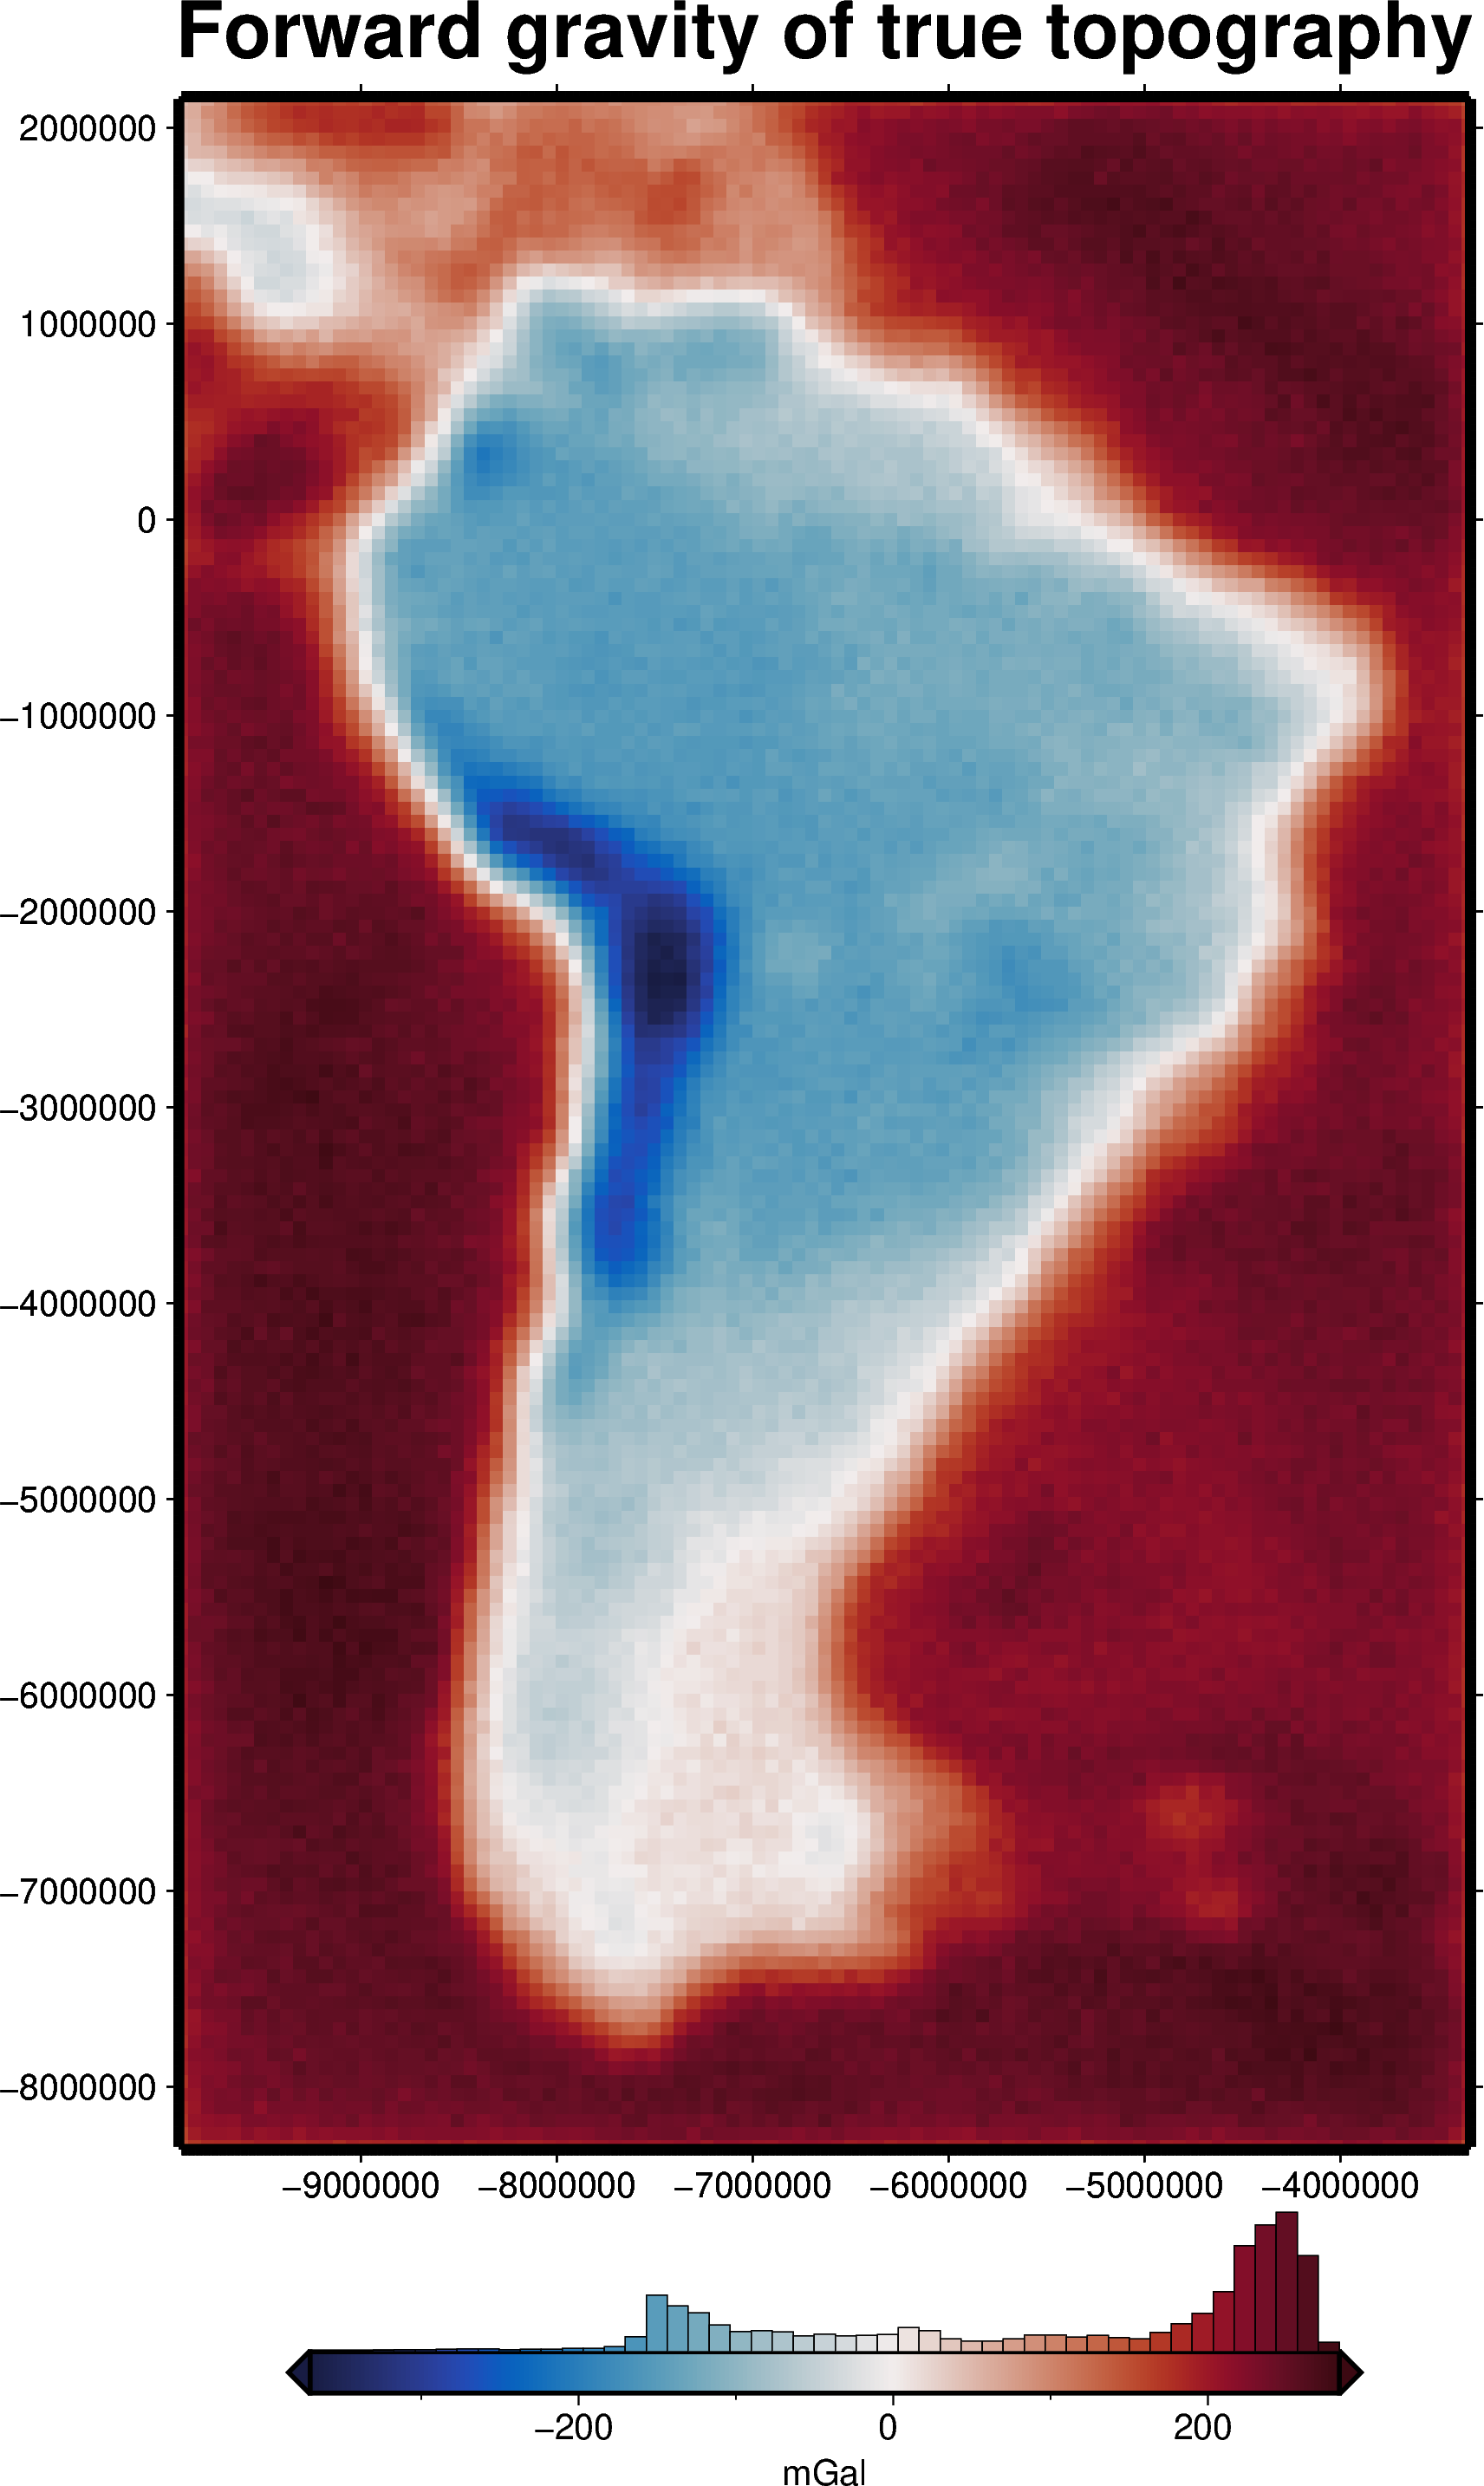

In [9]:
grav_grid = grav_df_resampled.set_index(["northing", "easting"]).to_xarray()

fig = maps.plot_grd(
    grav_grid.gravity_anomaly,
    fig_height=20,
    title="Forward gravity of true topography",
    hist=True,
    cbar_yoffset=2,
    cmap="balance+h0",
    cbar_label="mGal",
    # robust=True,
    frame=["nSWe", "xaf10000", "yaf10000"],
)
fig.show()

# Starting model
Following the paper's approach, we create a starting model which uses the true values of the density contrast and reference level for the Moho. This is used during the damping parameter cross-validation.

In [10]:
true_zref, true_density_contrast

(-30000.0, 350)

In [11]:
# create flat topography grid with a constant height equal the mean of the starting
# topography (zref)
zref = true_zref
density_contrast = true_density_contrast
starting_topography = xr.full_like(true_moho, zref)

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density_grid = xr.where(
    starting_topography >= zref, density_contrast, -density_contrast
)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    zref,
    density=density_grid,
)

# since our starting model is flat, the starting gravity is 0
grav_df_resampled["starting_gravity"] = 0

# in many cases, we want to remove a regional signal from the misfit to isolate the
# residual signal. In this simple case, we assume there is no regional misfit and set
# it to 0
grav_df_resampled = regional.regional_separation(
    method="constant",
    constant=0,
    grav_df=grav_df_resampled,
)
grav_df_resampled

northing    easting   test   upward  gravity_anomaly  \
0     -8308000.0 -9916000.0  False  50000.0       149.679489   
1     -8308000.0 -9849000.0   True  50000.0       168.821051   
2     -8308000.0 -9782000.0  False  50000.0       181.023137   
3     -8308000.0 -9715000.0   True  50000.0       182.558062   
4     -8308000.0 -9648000.0  False  50000.0       181.831163   
...          ...        ...    ...      ...              ...   
15538  2144000.0 -3618000.0  False  50000.0       183.238536   
15539  2144000.0 -3551000.0   True  50000.0       180.454881   
15540  2144000.0 -3484000.0  False  50000.0       172.672940   
15541  2144000.0 -3417000.0   True  50000.0       167.308086   
15542  2144000.0 -3350000.0  False  50000.0       147.883445   

       starting_gravity      misfit  reg         res  
0                     0  149.679489    0  149.679489  
1                     0  168.821051    0  168.821051  
2                     0  181.023137    0  181.023137  
3                     0  182.558062    0  182.558062  
4                     0  181.831163    0  181.831163  
...                 ...         ...  ...         ...  
15538                 0  183.238536    0  183.238536  
15539                 0  180.454881    0  180.454881  
15540                 0  172.672940    0  172.672940  
15541                 0  167.308086    0  167.308086  
15542                 0  147.883445    0  147.883445  

[15543 rows x 9 columns]

# Damping parameter cross validation

## Get individual score

We will perform an inversion with a single damping value and calculate a `score` for it. The grid shows how to `score` is calculated, as the RMS difference between the predicted and observed gravity data.

  0%|          | 0/11593 [00:00<?, ?it/s]

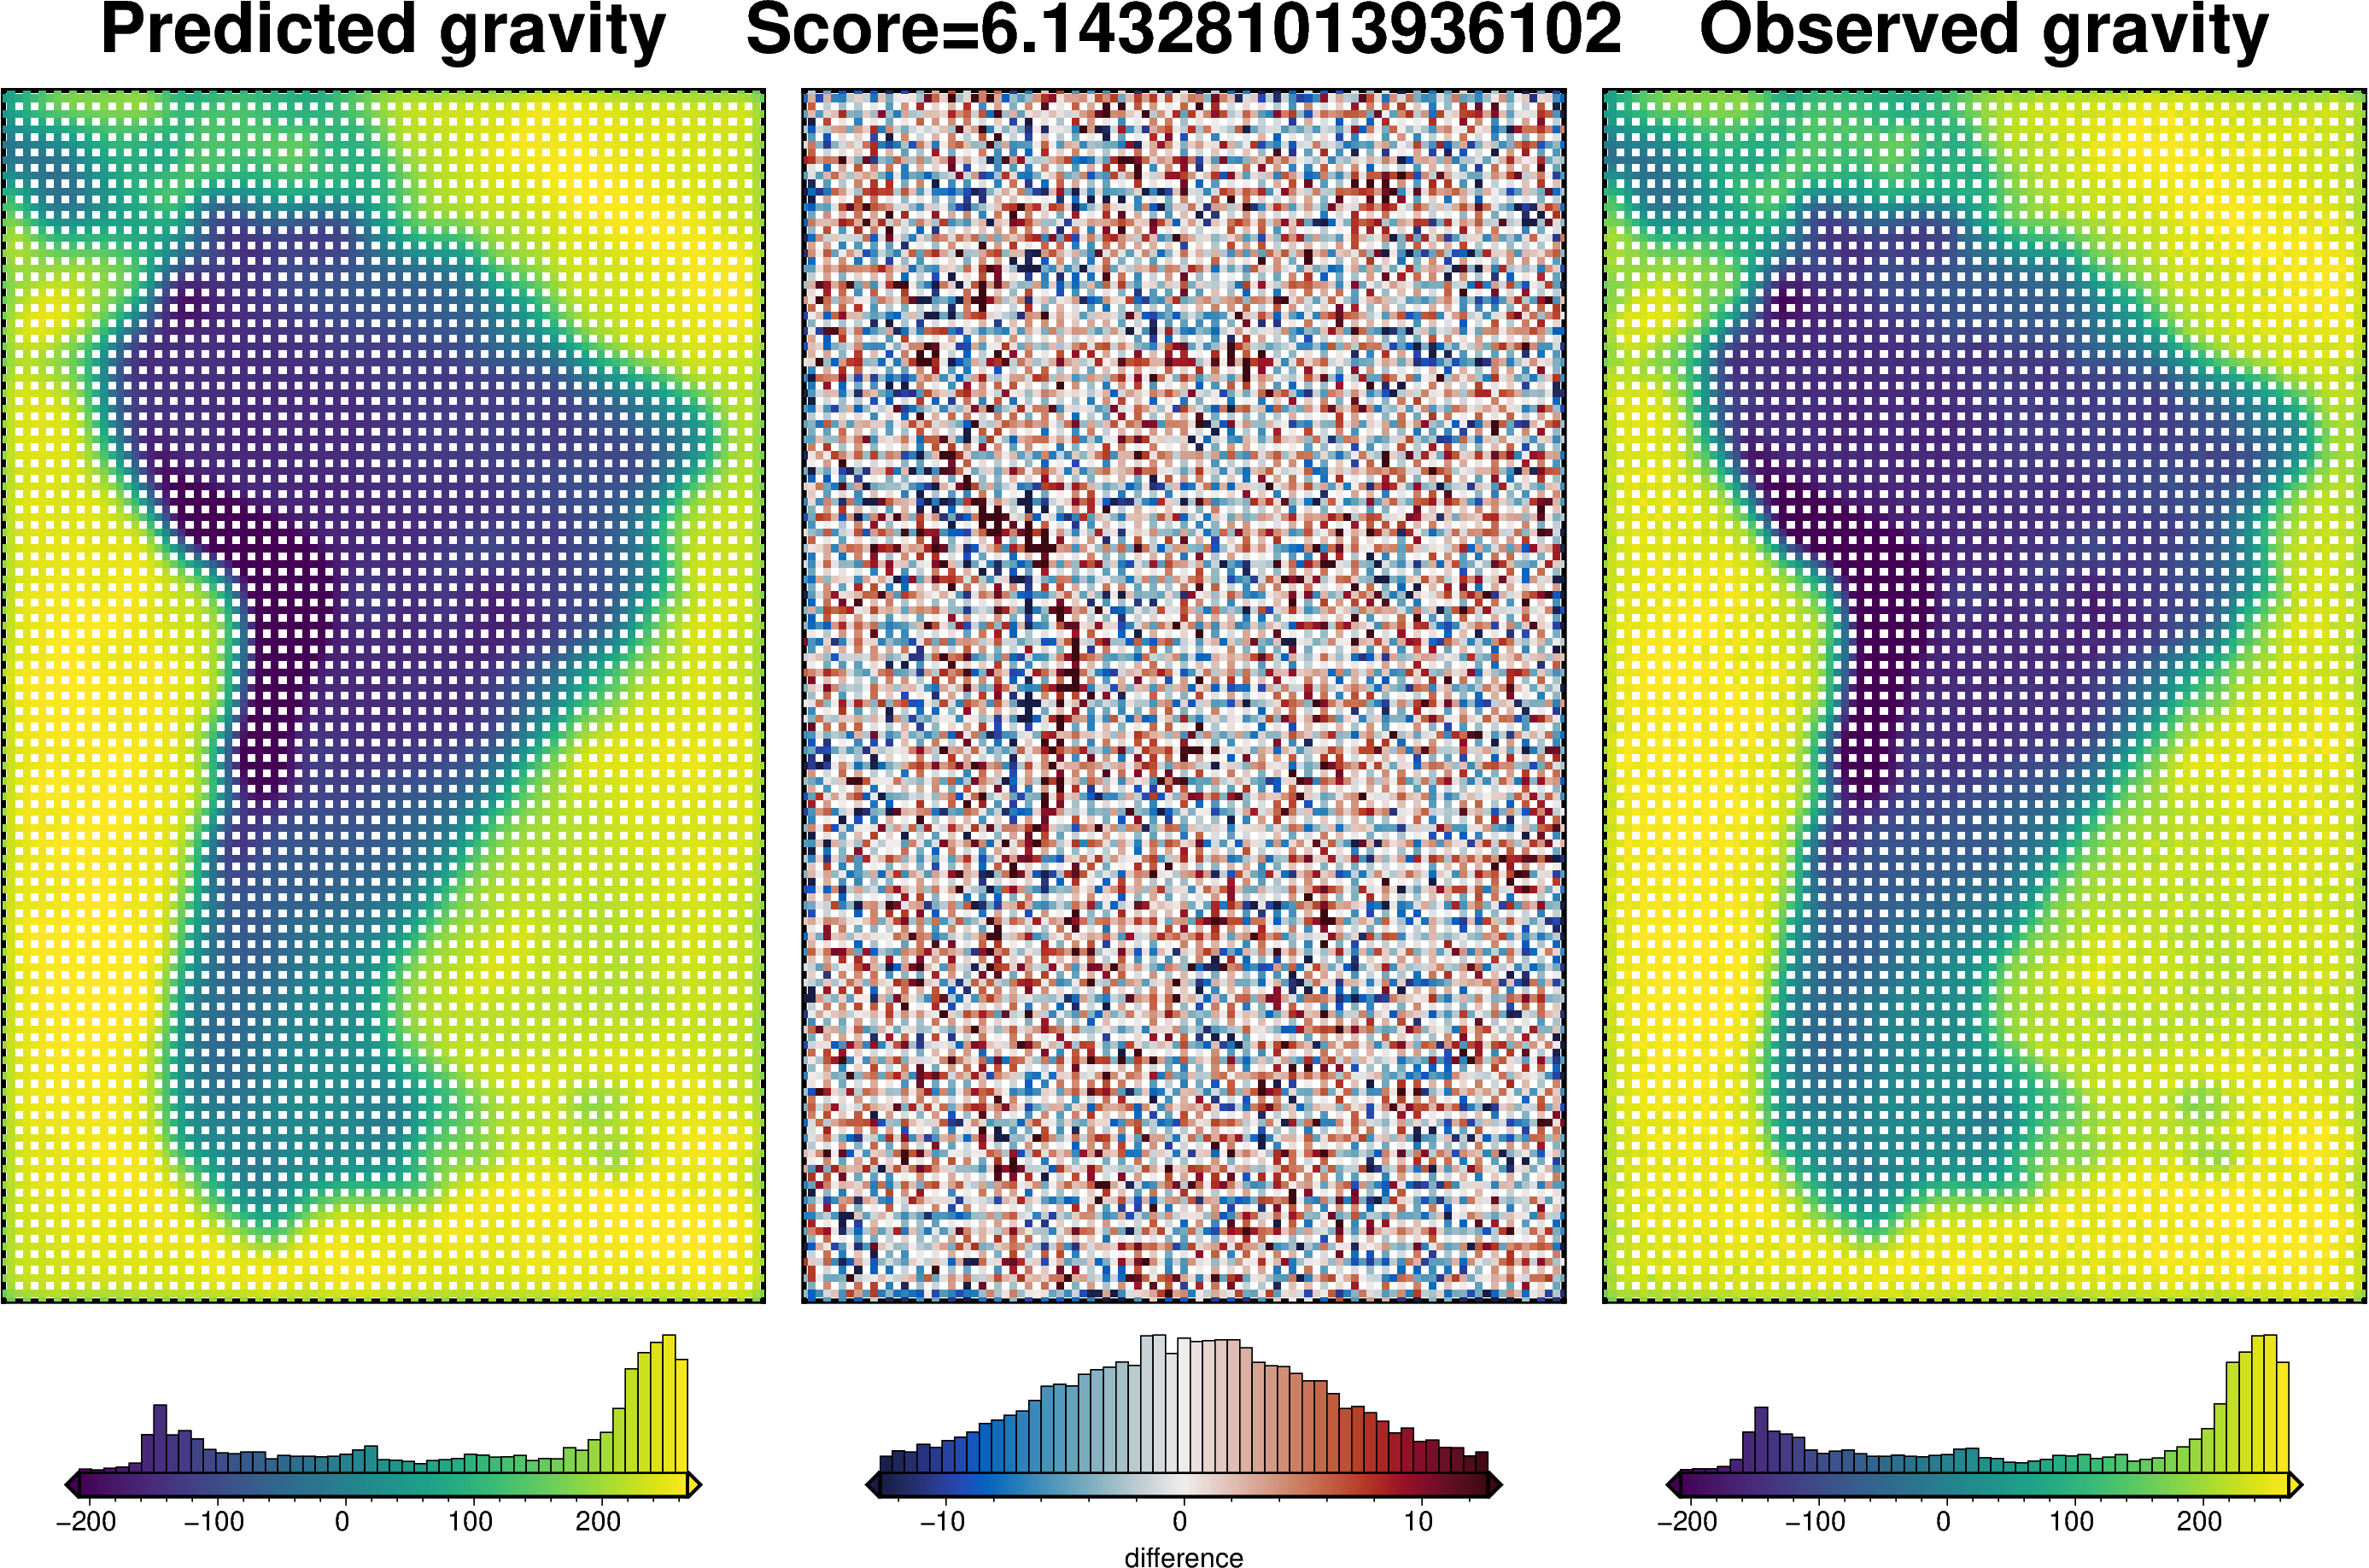

np.float64(6.143281013936102)

In [12]:
# set the inversions stopping criteria
kwargs = {
    "max_iterations": 300,
    "l2_norm_tolerance": 2.2,  # L2-norm of the misfit
    "delta_l2_norm_tolerance": 1.008,  # ratio of the L2-norm between iterations,
}

# run inversion, calculate the score, and plot the predicted and observed gravity for
# the testing dataset
score, results = cross_validation.grav_cv_score(
    training_data=grav_df_resampled[grav_df_resampled.test == False],
    testing_data=grav_df_resampled[grav_df_resampled.test == True],
    prism_layer=starting_prisms,
    solver_damping=0.01,
    progressbar=True,
    plot=True,
    **kwargs,
)
score

## Cross Validation Optimization

INFO:invert4geom:using 4 startup trials


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 6
INFO:invert4geom:	parameter: {'damping': 0.005495105702110278}
INFO:invert4geom:	scores: [5.975696888892725]


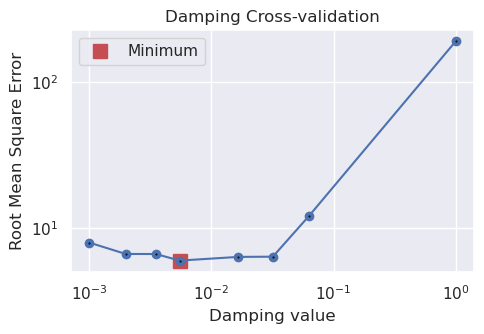

In [13]:
study, inversion_results = optimization.optimize_inversion_damping(
    training_df=grav_df_resampled[grav_df_resampled.test == False],
    testing_df=grav_df_resampled[grav_df_resampled.test == True],
    prism_layer=starting_prisms,
    damping_limits=(0.001, 1),
    n_trials=8,
    # grid_search=True,
    # plot_grids=True,
    fname="../tmp/uieda_CRUST1_damping_CV",
    **kwargs,
)

In [14]:
# to re-load the study from the saved pickle file
with pathlib.Path("../tmp/uieda_CRUST1_damping_CV_study.pickle").open("rb") as f:
    study = pickle.load(f)

# to re-load the inversion results from the saved pickle file
with pathlib.Path("../tmp/uieda_CRUST1_damping_CV_results.pickle").open("rb") as f:
    inversion_results = pickle.load(f)

# collect the results
topo_results, grav_results, parameters, elapsed_time = inversion_results

In [15]:
best_damping = study.best_params.get("damping")
best_damping

0.005495105702110278

The above plot shows the results of the damping parameter cross validation, and is equivalent to Figure 7a in the paper. The main difference is that we use a optimization approach instead of a grid search. This allows us to find the best value in fewer trials, as the parameter search space is quickly narrowed down. We performed 8 trials, compared to the 16 trials used in the paper.

## Plot results

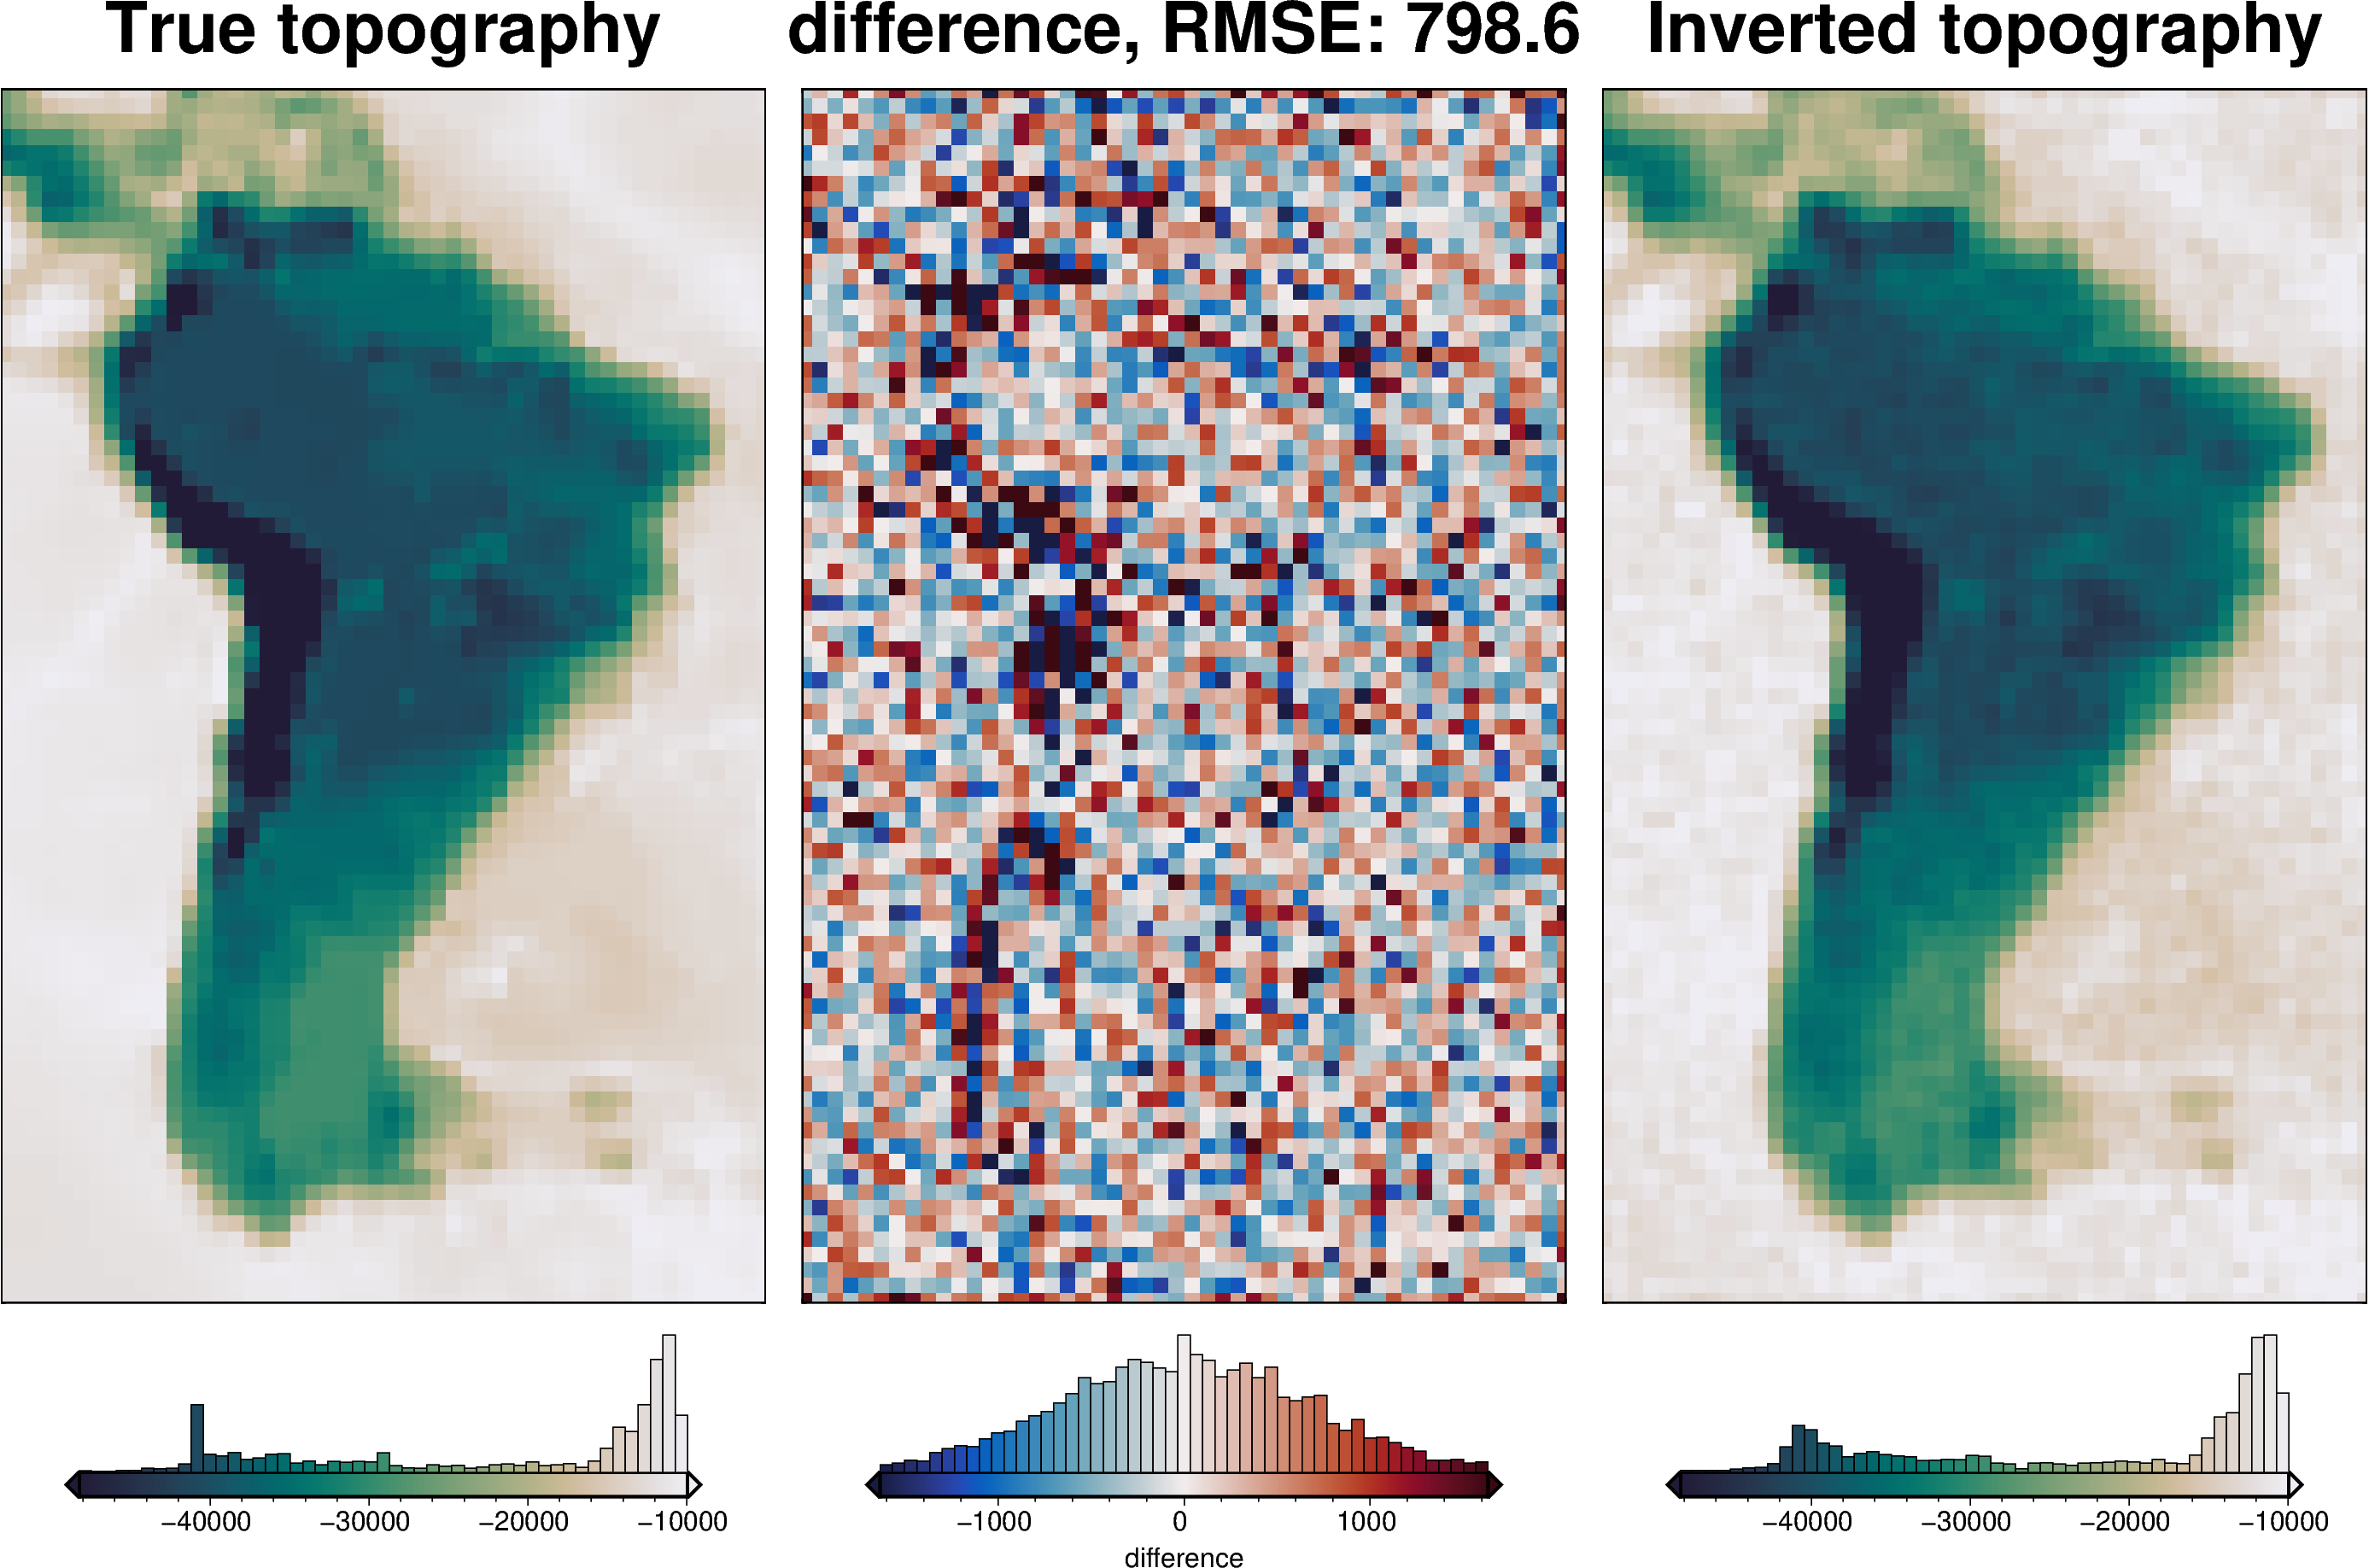

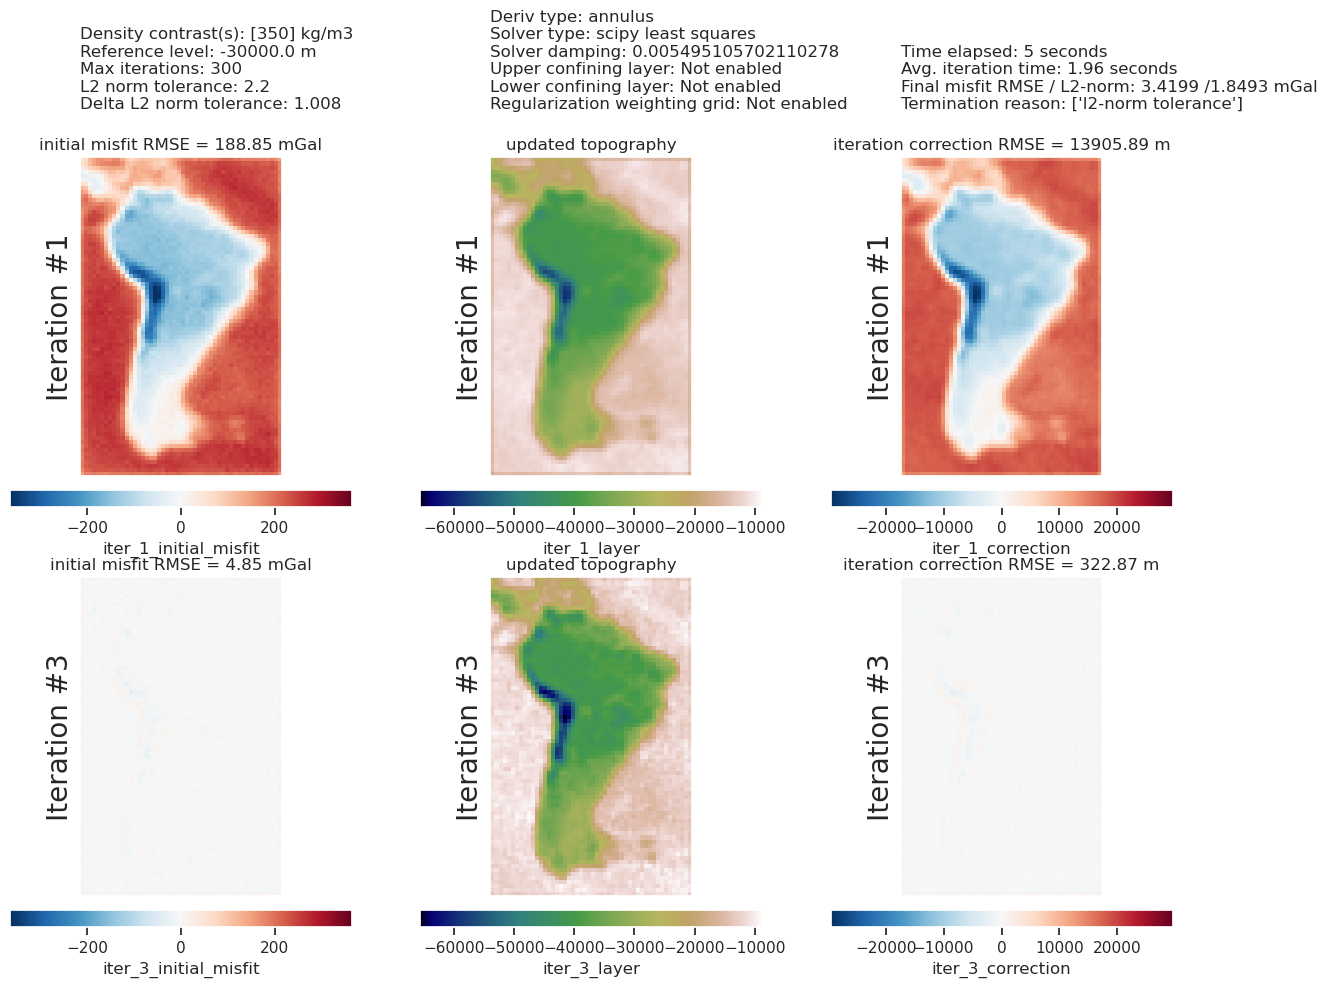

In [16]:
plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=False,
    plot_grav_results=False,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    true_moho,
    final_topography,
    plot=True,
    region=region,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
)

In [17]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
)

rmse = utils.rmse(constraint_points.upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 1040.22 m


# Density / Reference level cross validation

Now that we have a optimal damping value, we can perform a cross-validation to find the optimal values for density contrast and reference level. For these, we pick a range of possible values, and perform a hyperparameter optimization to find the best set of values.

In [18]:
# drop testing data
grav_df = grav_df_resampled[grav_df_resampled.test == False]
grav_df = grav_df.drop(columns=["test"])
grav_df

northing    easting   upward  gravity_anomaly  starting_gravity  \
0     -8308000.0 -9916000.0  50000.0       149.679489                 0   
2     -8308000.0 -9782000.0  50000.0       181.023137                 0   
4     -8308000.0 -9648000.0  50000.0       181.831163                 0   
6     -8308000.0 -9514000.0  50000.0       193.791533                 0   
8     -8308000.0 -9380000.0  50000.0       185.269207                 0   
...          ...        ...      ...              ...               ...   
15534  2144000.0 -3886000.0  50000.0       190.038049                 0   
15536  2144000.0 -3752000.0  50000.0       175.462622                 0   
15538  2144000.0 -3618000.0  50000.0       183.238536                 0   
15540  2144000.0 -3484000.0  50000.0       172.672940                 0   
15542  2144000.0 -3350000.0  50000.0       147.883445                 0   

           misfit  reg         res  
0      149.679489    0  149.679489  
2      181.023137    0  181.023137  
4      181.831163    0  181.831163  
6      193.791533    0  193.791533  
8      185.269207    0  185.269207  
...           ...  ...         ...  
15534  190.038049    0  190.038049  
15536  175.462622    0  175.462622  
15538  183.238536    0  183.238536  
15540  172.672940    0  172.672940  
15542  147.883445    0  147.883445  

[3950 rows x 8 columns]

INFO:invert4geom:using 8 startup trials


  0%|          | 0/8 [00:00<?, ?it/s]

INFO:invert4geom:starting_topography not provided, creating a starting topography model with the supplied starting_topography_kwargs
INFO:invert4geom:using zref to create a flat starting topography model


  0%|          | 0/12 [00:00<?, ?it/s]

INFO:invert4geom:starting_topography not provided, creating a starting topography model with the supplied starting_topography_kwargs
INFO:invert4geom:using zref to create a flat starting topography model
INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 15
INFO:invert4geom:	parameter: {'zref': -30007.07804892218, 'density_contrast': 352}
INFO:invert4geom:	scores: [1317.743672232401]


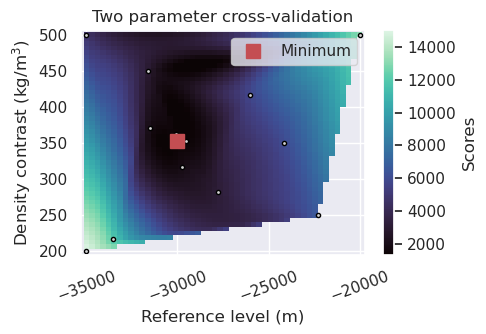

In [19]:
# run the cross validation for the zref and density
study, inversion_results = optimization.optimize_inversion_zref_density_contrast(
    grav_df=grav_df,
    solver_damping=best_damping,
    constraints_df=constraint_points,
    density_contrast_limits=(200, 500),
    zref_limits=(-35e3, -20e3),
    n_trials=20,
    starting_topography_kwargs=dict(
        method="flat",
        region=region,
        spacing=spacing,
    ),
    regional_grav_kwargs={
        "method": "constant",
        "constant": 0,
    },
    # grid_search=True,
    fname="../tmp/uieda_CRUST1_zref_density_cv",
    # score_as_median=True,
    **kwargs,
)

In [20]:
# to re-load the study from the saved pickle file
with pathlib.Path("../tmp/uieda_CRUST1_zref_density_cv_study.pickle").open("rb") as f:
    study = pickle.load(f)

# to re-load the inversion results from the saved pickle file
with pathlib.Path("../tmp/uieda_CRUST1_zref_density_cv_results.pickle").open("rb") as f:
    inversion_results = pickle.load(f)

# collect the results
topo_results, grav_results, parameters, elapsed_time = inversion_results

In [21]:
best_zref = study.best_params.get("zref")
best_density_contrast = study.best_params.get("density_contrast")

best_zref, true_zref

(-30007.07804892218, -30000.0)

In [22]:
best_density_contrast, true_density_contrast

(352, 350)

The above plot shows the results of the cross validation and is equivalent to Figure 7b in the paper. The optimal values they report are zref = 30 km and density contrast = 350 kg/m-3, which are the same as the values we find. The main difference is that they used a grid-search approach, testing evenly-spaced values between -35 and -20 km, and between 500 and 200 kg/m-3. We instead used an optimization approach, where the parameters space is smartly searched based on the scores of the past trials. As you can see, this allows us to find the optimal values in far fewer trials. Here we used 20 trials, compared to the 49 trials used in the paper.

We also support the grid-search approach, which can be enabled with `grid_search=True` in the above function.

## Plot results

The below plots show the inversion results used the optimal damping, density contrast, and reference level values. 

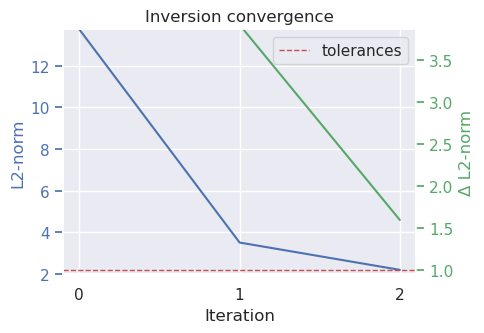

In [23]:
plotting.plot_convergence(
    grav_results,
    parameters,
)

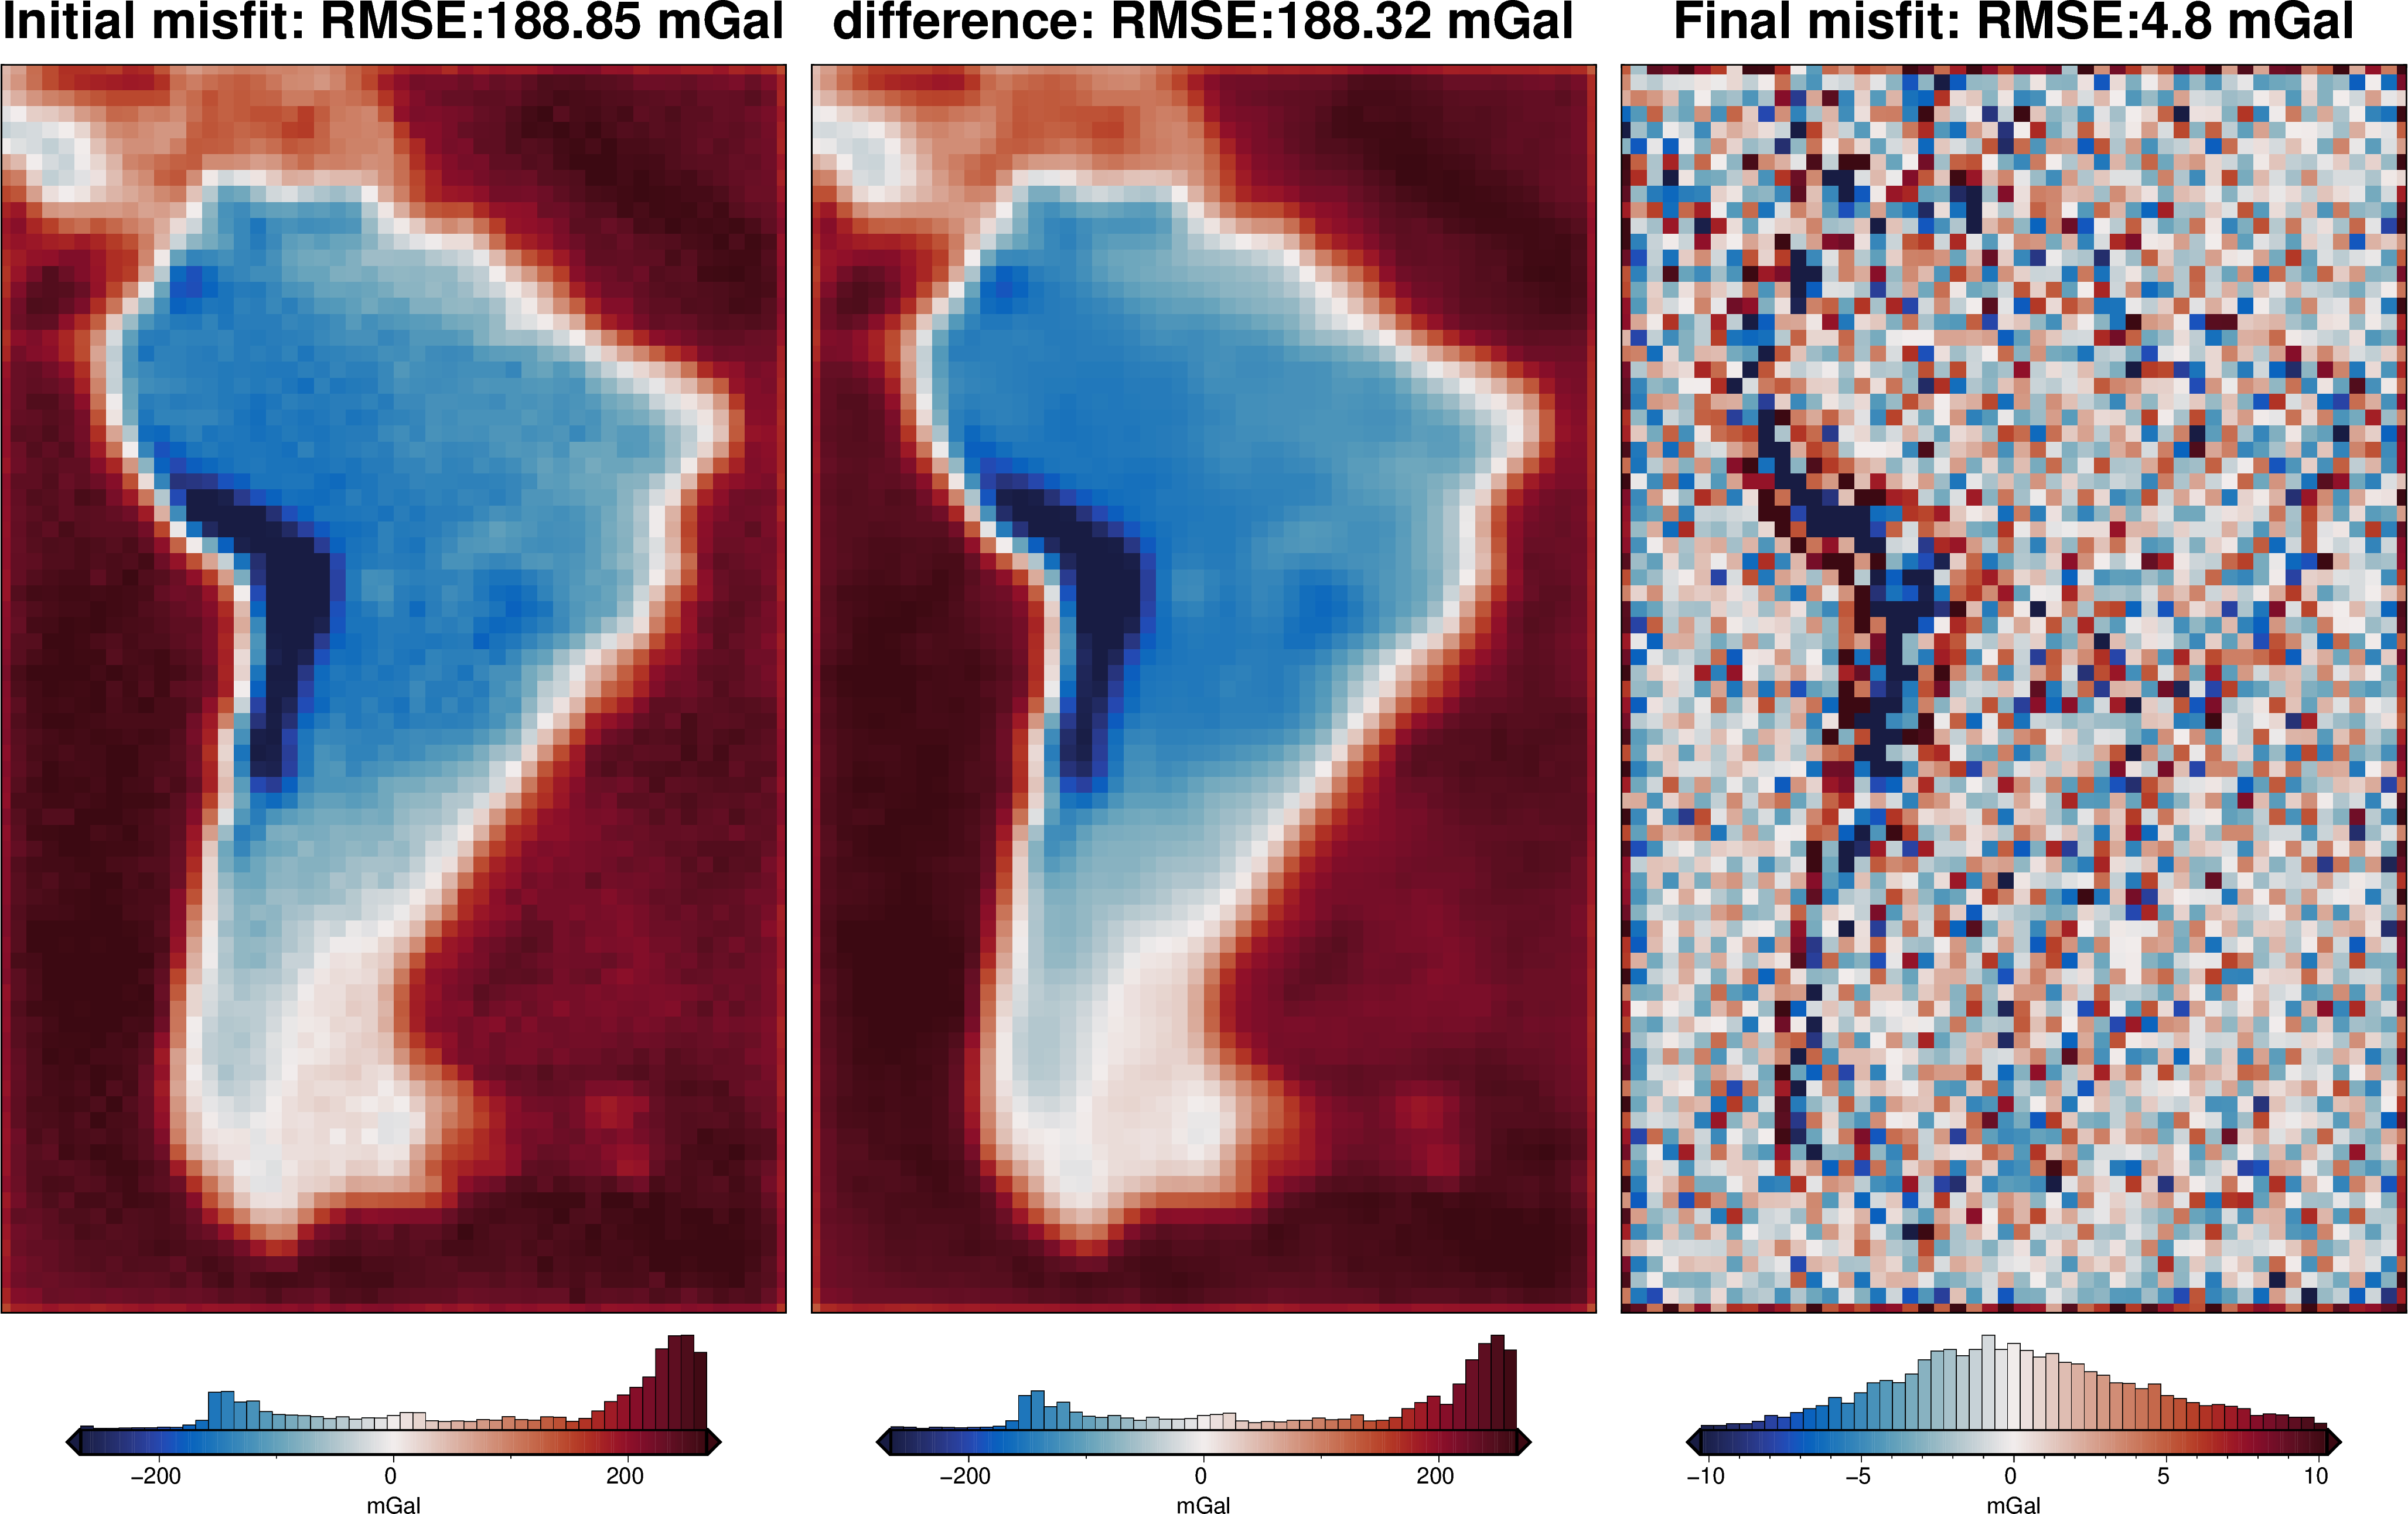

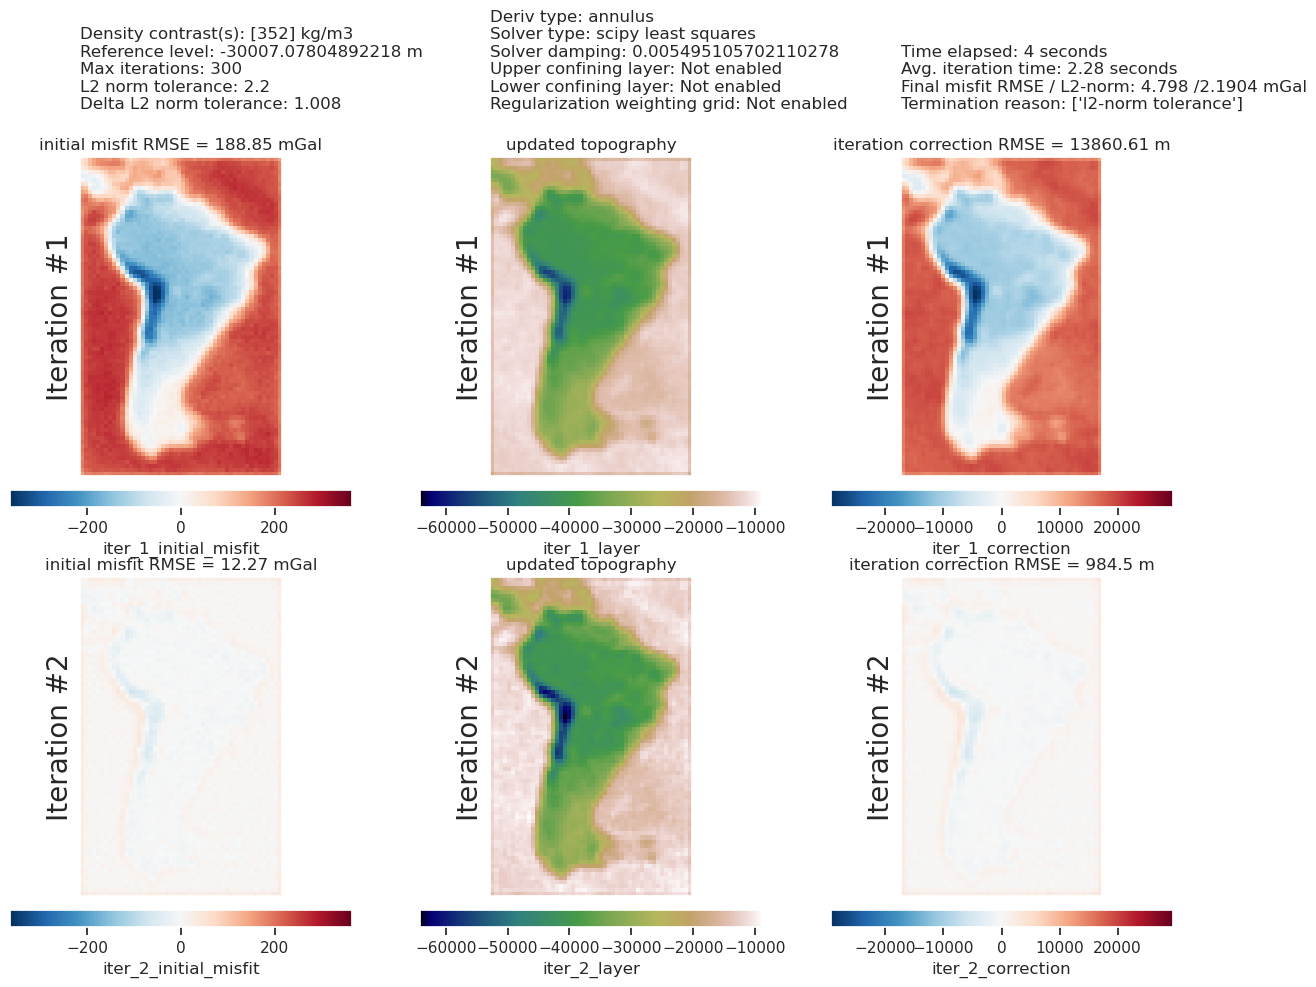

In [24]:
plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=False,
    plot_grav_results=True,
    fig_height=18,
)

The top plot above compares gravity misfit before and after the inversion. The right subplot is equivalent to Figure 7g in the paper. 

The lower plot shows the iteration results of the inversion, and has all the parameter values and metadata at the top. From this, you can see the inversion terminated after 2 iterations due to the inversion reaching the set L2-norm tolerance. 

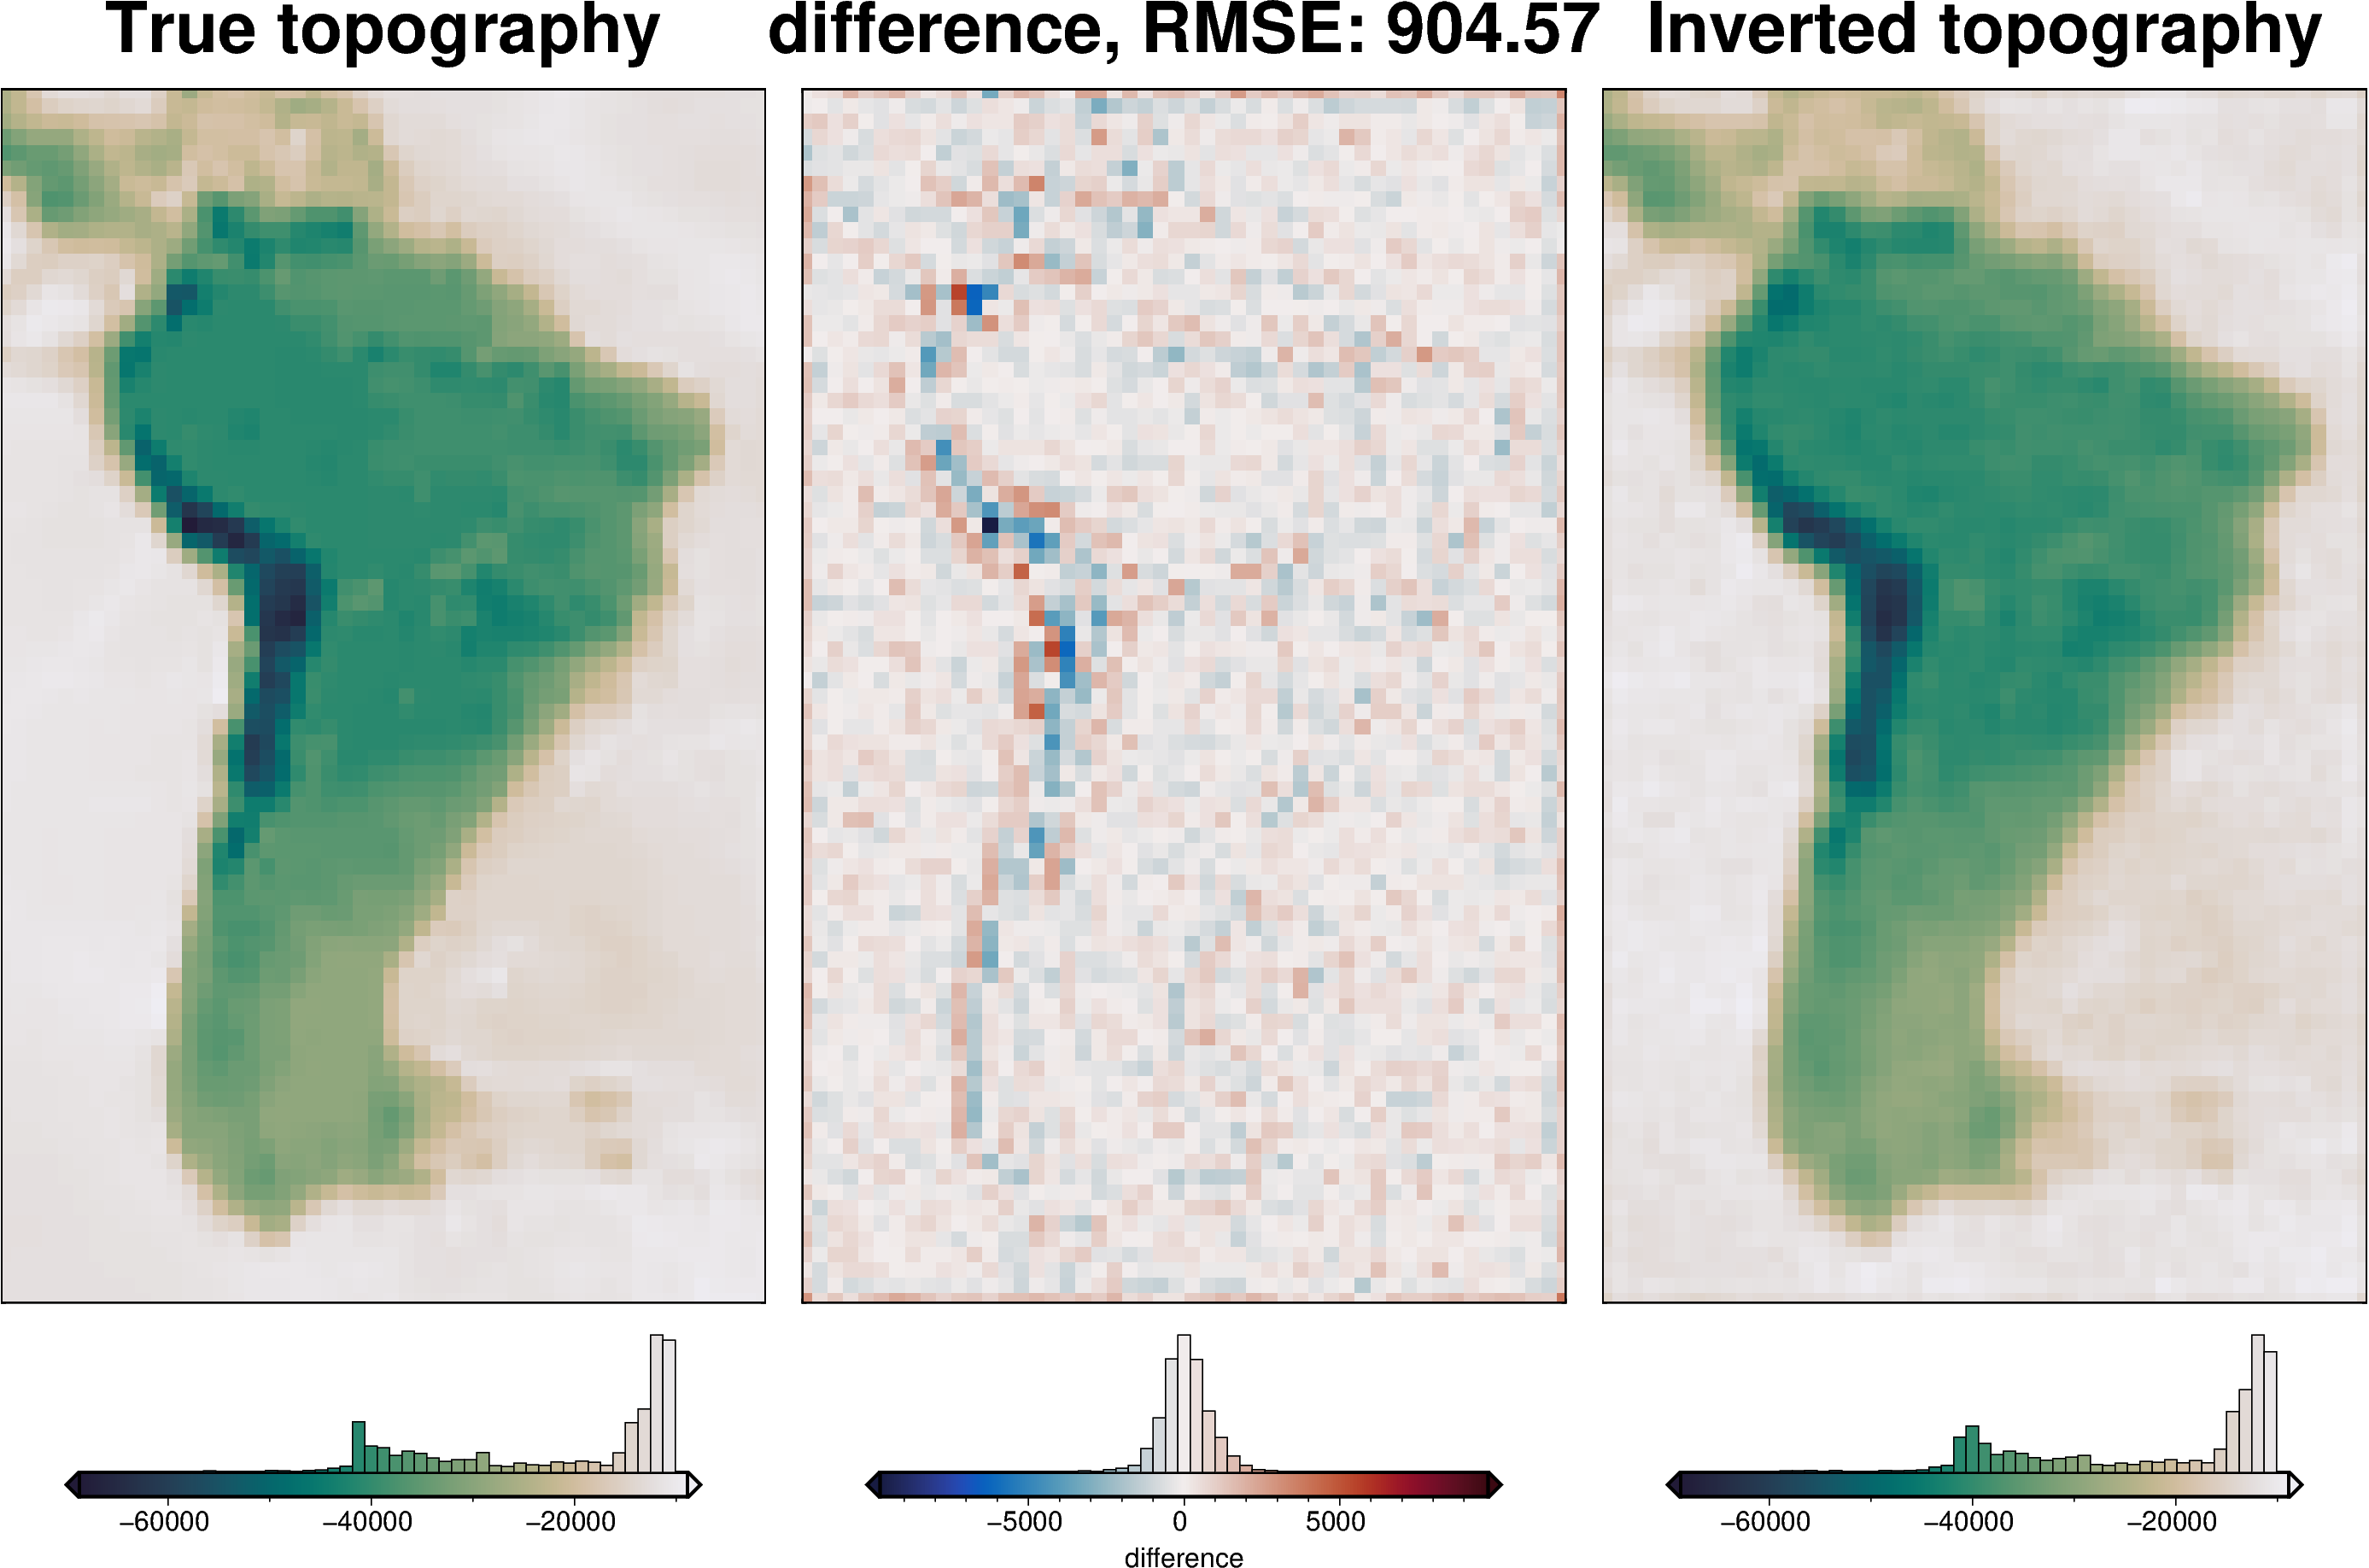

In [25]:
final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    true_moho,
    final_topography,
    plot=True,
    region=region,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=False,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
)

The above plot shows the difference between the true and inverted topography and is equivalent to Figure 6d in the paper. The colorbar histogram of the middle subplot is equivalent to Figure 6f. The errors are normally distributed around 0, with a RMS of ~800m.

In [26]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
)

rmse = utils.rmse(constraint_points.upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 1317.74 m


# Repeat with adhering to constraints
the above inversions only used the constraint points as a means to perform the cross validation. Below we will create a starting model from theses points and attempt to make the inversion adhere to the constraints.

## Starting model

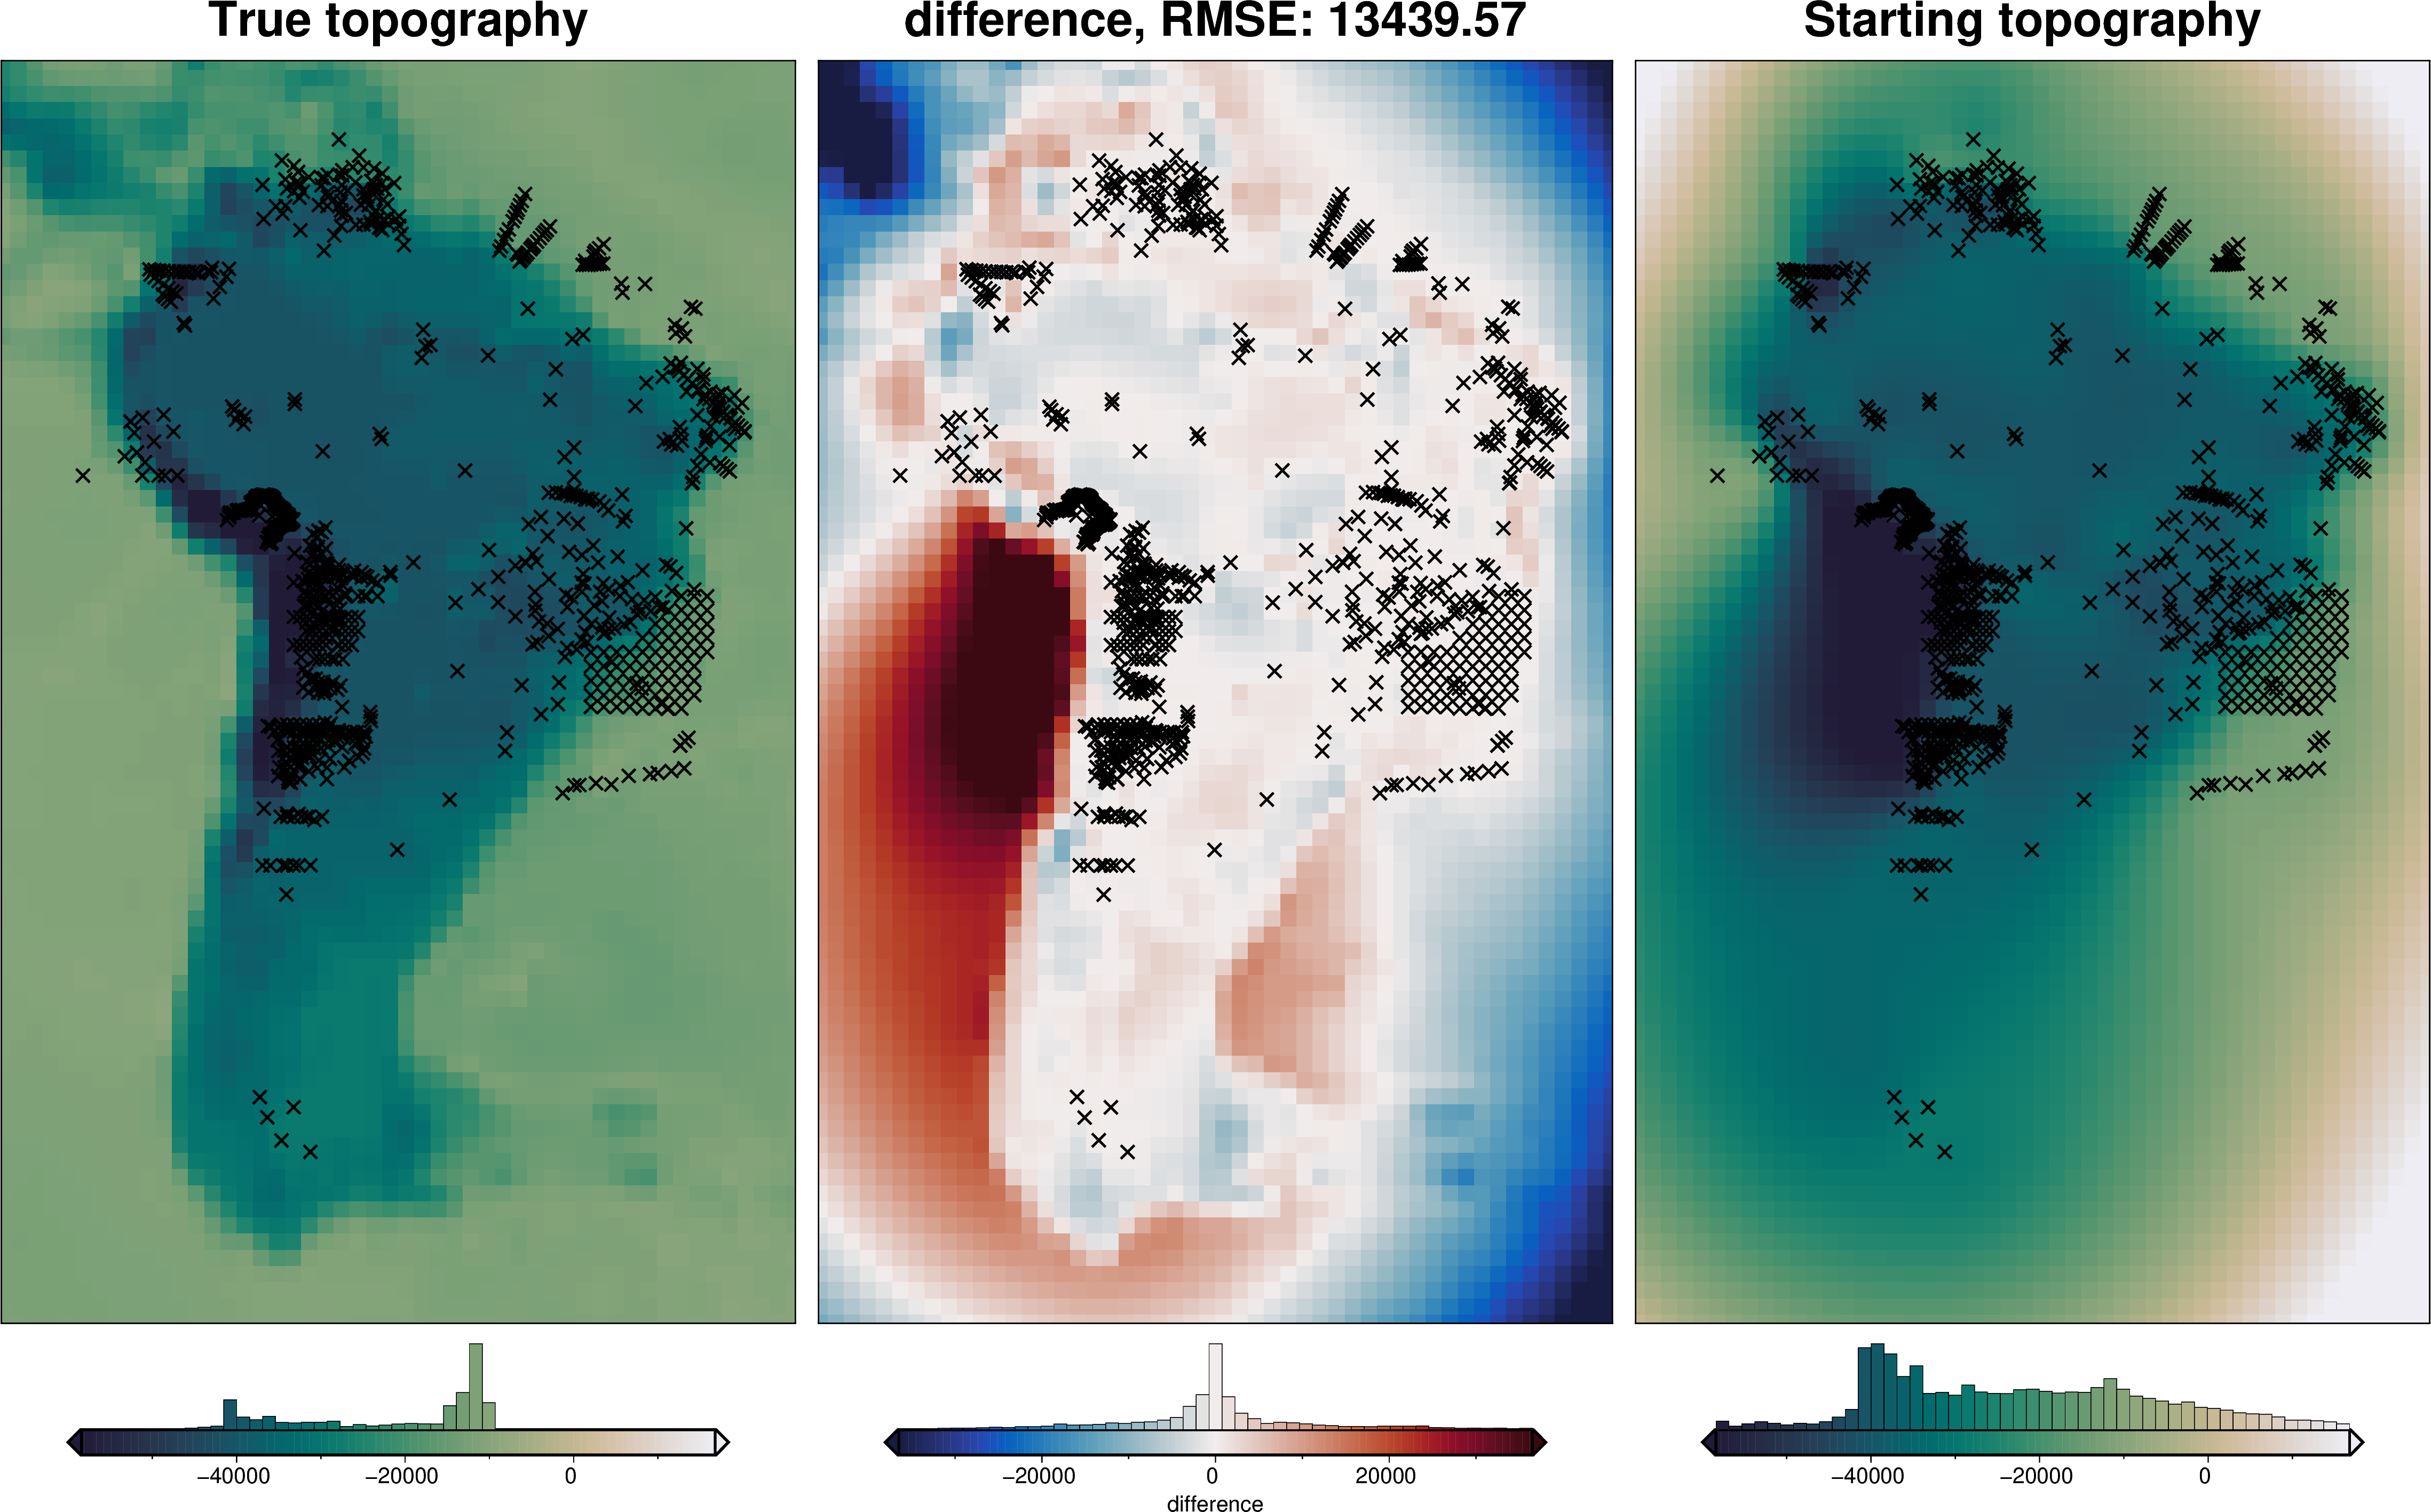

In [27]:
# grid the sampled values using verde
starting_topography = utils.create_topography(
    method="splines",
    region=region,
    spacing=spacing,
    constraints_df=constraint_points,
    dampings=None,  # np.logspace(-20, 0, 4),
)

_ = polar_utils.grd_compare(
    true_moho,
    starting_topography,
    fig_height=20,
    region=region,
    plot=True,
    grid1_name="True topography",
    grid2_name="Starting topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.3c",
)

In [28]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    starting_topography,
    "starting_topography",
)

rmse = utils.rmse(constraint_points.upward - constraint_points.starting_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 232.74 m


## Gravity misfit

All inversions in Invert4Geom are based on a gravity misfit, not a gravity anomaly. This means before the inversion, we must create a starting prism model, forward model it's gravity effect, remove it from the gravity anomaly, and get a gravity misfit. 

Following the approach from the paper, for the damping parameter cross validation, we assume we know the true values for the density contrast and the reference level.

In [29]:
true_density_contrast, true_zref

(350, -30000.0)

MESA: error: ZINK: failed to choose pdev
glx: failed to create drisw screen


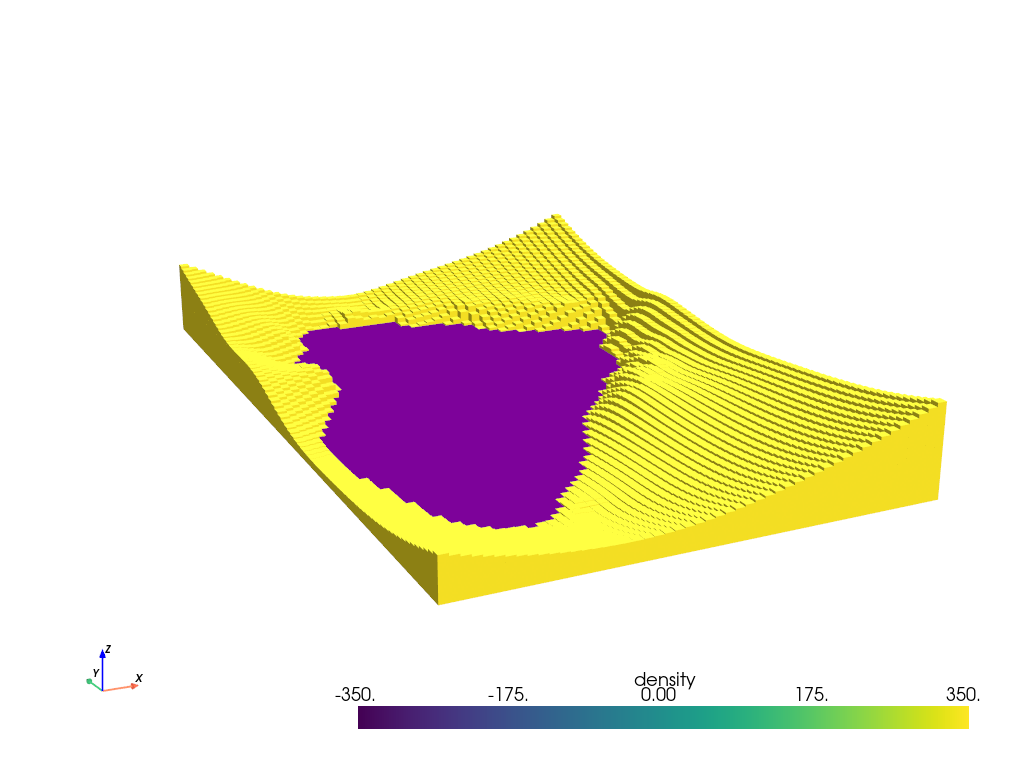

  0%|          | 0/15543 [00:00<?, ?it/s]

northing    easting   test   upward  gravity_anomaly  \
0     -8308000.0 -9916000.0  False  50000.0       149.679489   
1     -8308000.0 -9849000.0   True  50000.0       168.821051   
2     -8308000.0 -9782000.0  False  50000.0       181.023137   
3     -8308000.0 -9715000.0   True  50000.0       182.558062   
4     -8308000.0 -9648000.0  False  50000.0       181.831163   
...          ...        ...    ...      ...              ...   
15538  2144000.0 -3618000.0  False  50000.0       183.238536   
15539  2144000.0 -3551000.0   True  50000.0       180.454881   
15540  2144000.0 -3484000.0  False  50000.0       172.672940   
15541  2144000.0 -3417000.0   True  50000.0       167.308086   
15542  2144000.0 -3350000.0  False  50000.0       147.883445   

       starting_gravity      misfit  reg         res  
0            245.768513  -96.089024    0  -96.089024  
1            270.390793 -101.569742    0 -101.569742  
2            273.837676  -92.814539    0  -92.814539  
3            270.977514  -88.419452    0  -88.419452  
4            265.453505  -83.622342    0  -83.622342  
...                 ...         ...  ...         ...  
15538        577.009811 -393.771276    0 -393.771276  
15539        590.073049 -409.618169    0 -409.618169  
15540        598.616429 -425.943489    0 -425.943489  
15541        597.753881 -430.445795    0 -430.445795  
15542        559.581766 -411.698321    0 -411.698321  

[15543 rows x 9 columns]

In [30]:
# choose reference levels
zref = true_zref
density_contrast = true_density_contrast

density_grid = xr.where(
    starting_topography >= zref, density_contrast, -density_contrast
)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    zref,
    density=density_grid,
)

plotting.show_prism_layers(
    starting_prisms,
    color_by="density",
    log_scale=False,
    zscale=20,
    backend="static",
)

# calculate forward gravity of starting prism layer
grav_df_resampled["starting_gravity"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df_resampled.easting,
        grav_df_resampled.northing,
        grav_df_resampled.upward,
    ),
    field="g_z",
    progressbar=True,
)

# in many cases, we want to remove a regional signal from the misfit to isolate the
# residual signal. In this simple case, we assume there is no regional misfit and set
# it to 0
grav_df_resampled = regional.regional_separation(
    method="constant",
    constant=0,
    grav_df=grav_df_resampled,
)
grav_df_resampled

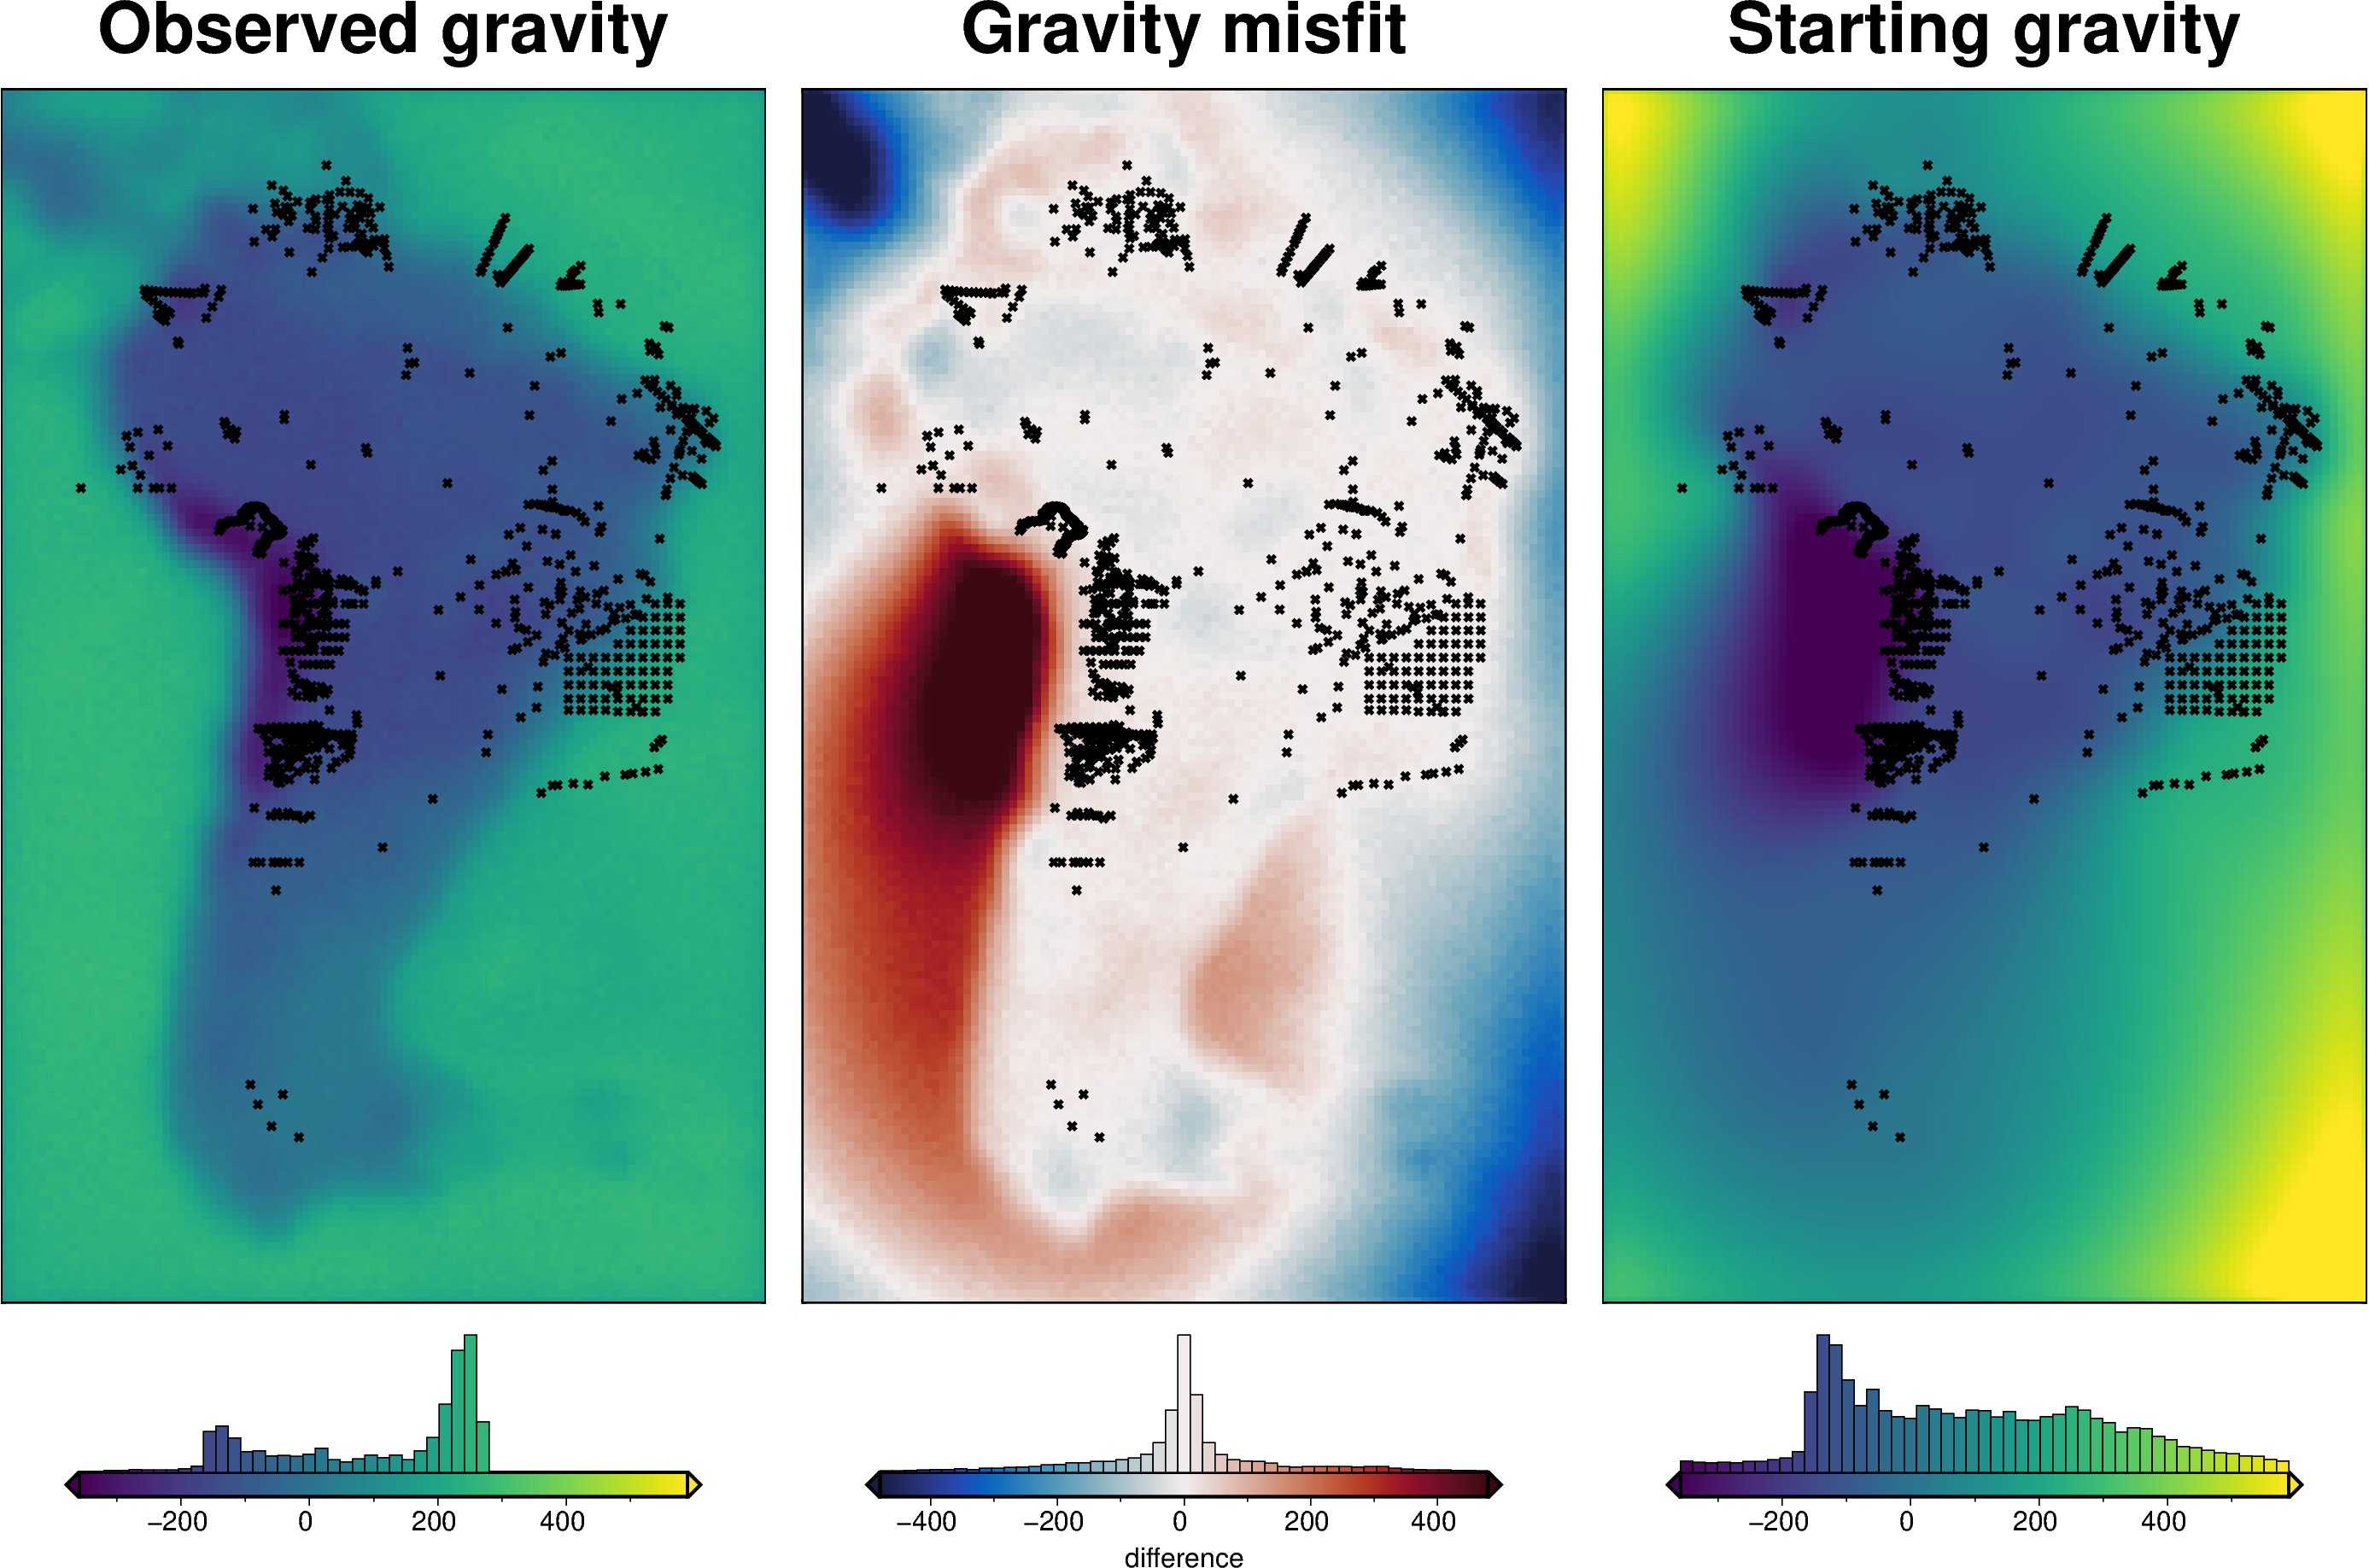

In [31]:
# grid the results
grav_grid = grav_df_resampled.set_index(["northing", "easting"]).to_xarray()

_ = polar_utils.grd_compare(
    grav_grid.gravity_anomaly,
    grav_grid.starting_gravity,
    plot=True,
    grid1_name="Observed gravity",
    grid2_name="Starting gravity",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="Gravity misfit",
    rmse_in_title=False,
    grounding_line=False,
    points=constraint_points,
    points_style="x.1c",
)

## Damping CV

INFO:invert4geom:using 4 startup trials


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 6
INFO:invert4geom:	parameter: {'damping': 0.0060234135971988624}
INFO:invert4geom:	scores: [5.9944783333517755]


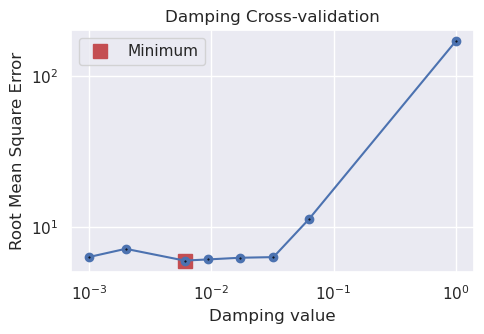

In [32]:
study, inversion_results = optimization.optimize_inversion_damping(
    training_df=grav_df_resampled[grav_df_resampled.test == False],
    testing_df=grav_df_resampled[grav_df_resampled.test == True],
    prism_layer=starting_prisms,
    damping_limits=(0.001, 1),
    n_trials=8,
    # grid_search=True,
    # plot_grids=True,
    fname="../tmp/uieda_CRUST1_damping_CV_with_starting_model",
    **kwargs,
)

In [33]:
# to re-load the study from the saved pickle file
with pathlib.Path(
    "../tmp/uieda_CRUST1_damping_CV_with_starting_model_study.pickle"
).open("rb") as f:
    study = pickle.load(f)

# to re-load the inversion results from the saved pickle file
with pathlib.Path(
    "../tmp/uieda_CRUST1_damping_CV_with_starting_model_results.pickle"
).open("rb") as f:
    inversion_results = pickle.load(f)

# collect the results
topo_results, grav_results, parameters, elapsed_time = inversion_results

In [34]:
best_damping = study.best_params.get("damping")
best_damping

0.0060234135971988624

## Density / Zref CV

In [35]:
# drop testing data
grav_df = grav_df_resampled[grav_df_resampled.test == False]
grav_df = grav_df.drop(columns=["test"])
grav_df

northing    easting   upward  gravity_anomaly  starting_gravity  \
0     -8308000.0 -9916000.0  50000.0       149.679489        245.768513   
2     -8308000.0 -9782000.0  50000.0       181.023137        273.837676   
4     -8308000.0 -9648000.0  50000.0       181.831163        265.453505   
6     -8308000.0 -9514000.0  50000.0       193.791533        251.936969   
8     -8308000.0 -9380000.0  50000.0       185.269207        237.613550   
...          ...        ...      ...              ...               ...   
15534  2144000.0 -3886000.0  50000.0       190.038049        517.983880   
15536  2144000.0 -3752000.0  50000.0       175.462622        547.917242   
15538  2144000.0 -3618000.0  50000.0       183.238536        577.009811   
15540  2144000.0 -3484000.0  50000.0       172.672940        598.616429   
15542  2144000.0 -3350000.0  50000.0       147.883445        559.581766   

           misfit  reg         res  
0      -96.089024    0  -96.089024  
2      -92.814539    0  -92.814539  
4      -83.622342    0  -83.622342  
6      -58.145436    0  -58.145436  
8      -52.344344    0  -52.344344  
...           ...  ...         ...  
15534 -327.945831    0 -327.945831  
15536 -372.454620    0 -372.454620  
15538 -393.771276    0 -393.771276  
15540 -425.943489    0 -425.943489  
15542 -411.698321    0 -411.698321  

[3950 rows x 8 columns]

INFO:invert4geom:using 8 startup trials


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 18
INFO:invert4geom:	parameter: {'zref': -30081.726831310218, 'density_contrast': 354}
INFO:invert4geom:	scores: [569.4001191488771]


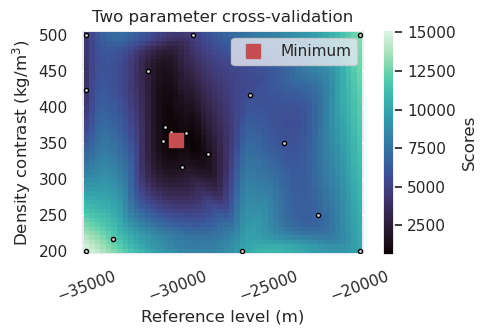

In [36]:
# run the cross validation for the zref and density
study, inversion_results = optimization.optimize_inversion_zref_density_contrast(
    grav_df=grav_df,
    constraints_df=constraint_points,
    solver_damping=best_damping,
    density_contrast_limits=(200, 500),
    zref_limits=(-35e3, -20e3),
    n_trials=20,
    starting_topography=starting_topography,
    regional_grav_kwargs={
        "method": "constant",
        "constant": 0,
    },
    # grid_search=True,
    fname="../tmp/uieda_CRUST1_zref_density_cv_with_starting_model",
    # score_as_median=True,
    **kwargs,
)

In [37]:
# to re-load the study from the saved pickle file
with pathlib.Path(
    "../tmp/uieda_CRUST1_zref_density_cv_with_starting_model_study.pickle"
).open("rb") as f:
    study = pickle.load(f)

# to re-load the inversion results from the saved pickle file
with pathlib.Path(
    "../tmp/uieda_CRUST1_zref_density_cv_with_starting_model_results.pickle"
).open("rb") as f:
    inversion_results = pickle.load(f)

# collect the results
topo_results, grav_results, parameters, elapsed_time = inversion_results

In [38]:
best_zref = study.best_params.get("zref")
best_density_contrast = study.best_params.get("density_contrast")

best_zref, true_zref

(-30081.726831310218, -30000.0)

In [39]:
best_density_contrast, true_density_contrast

(354, 350)

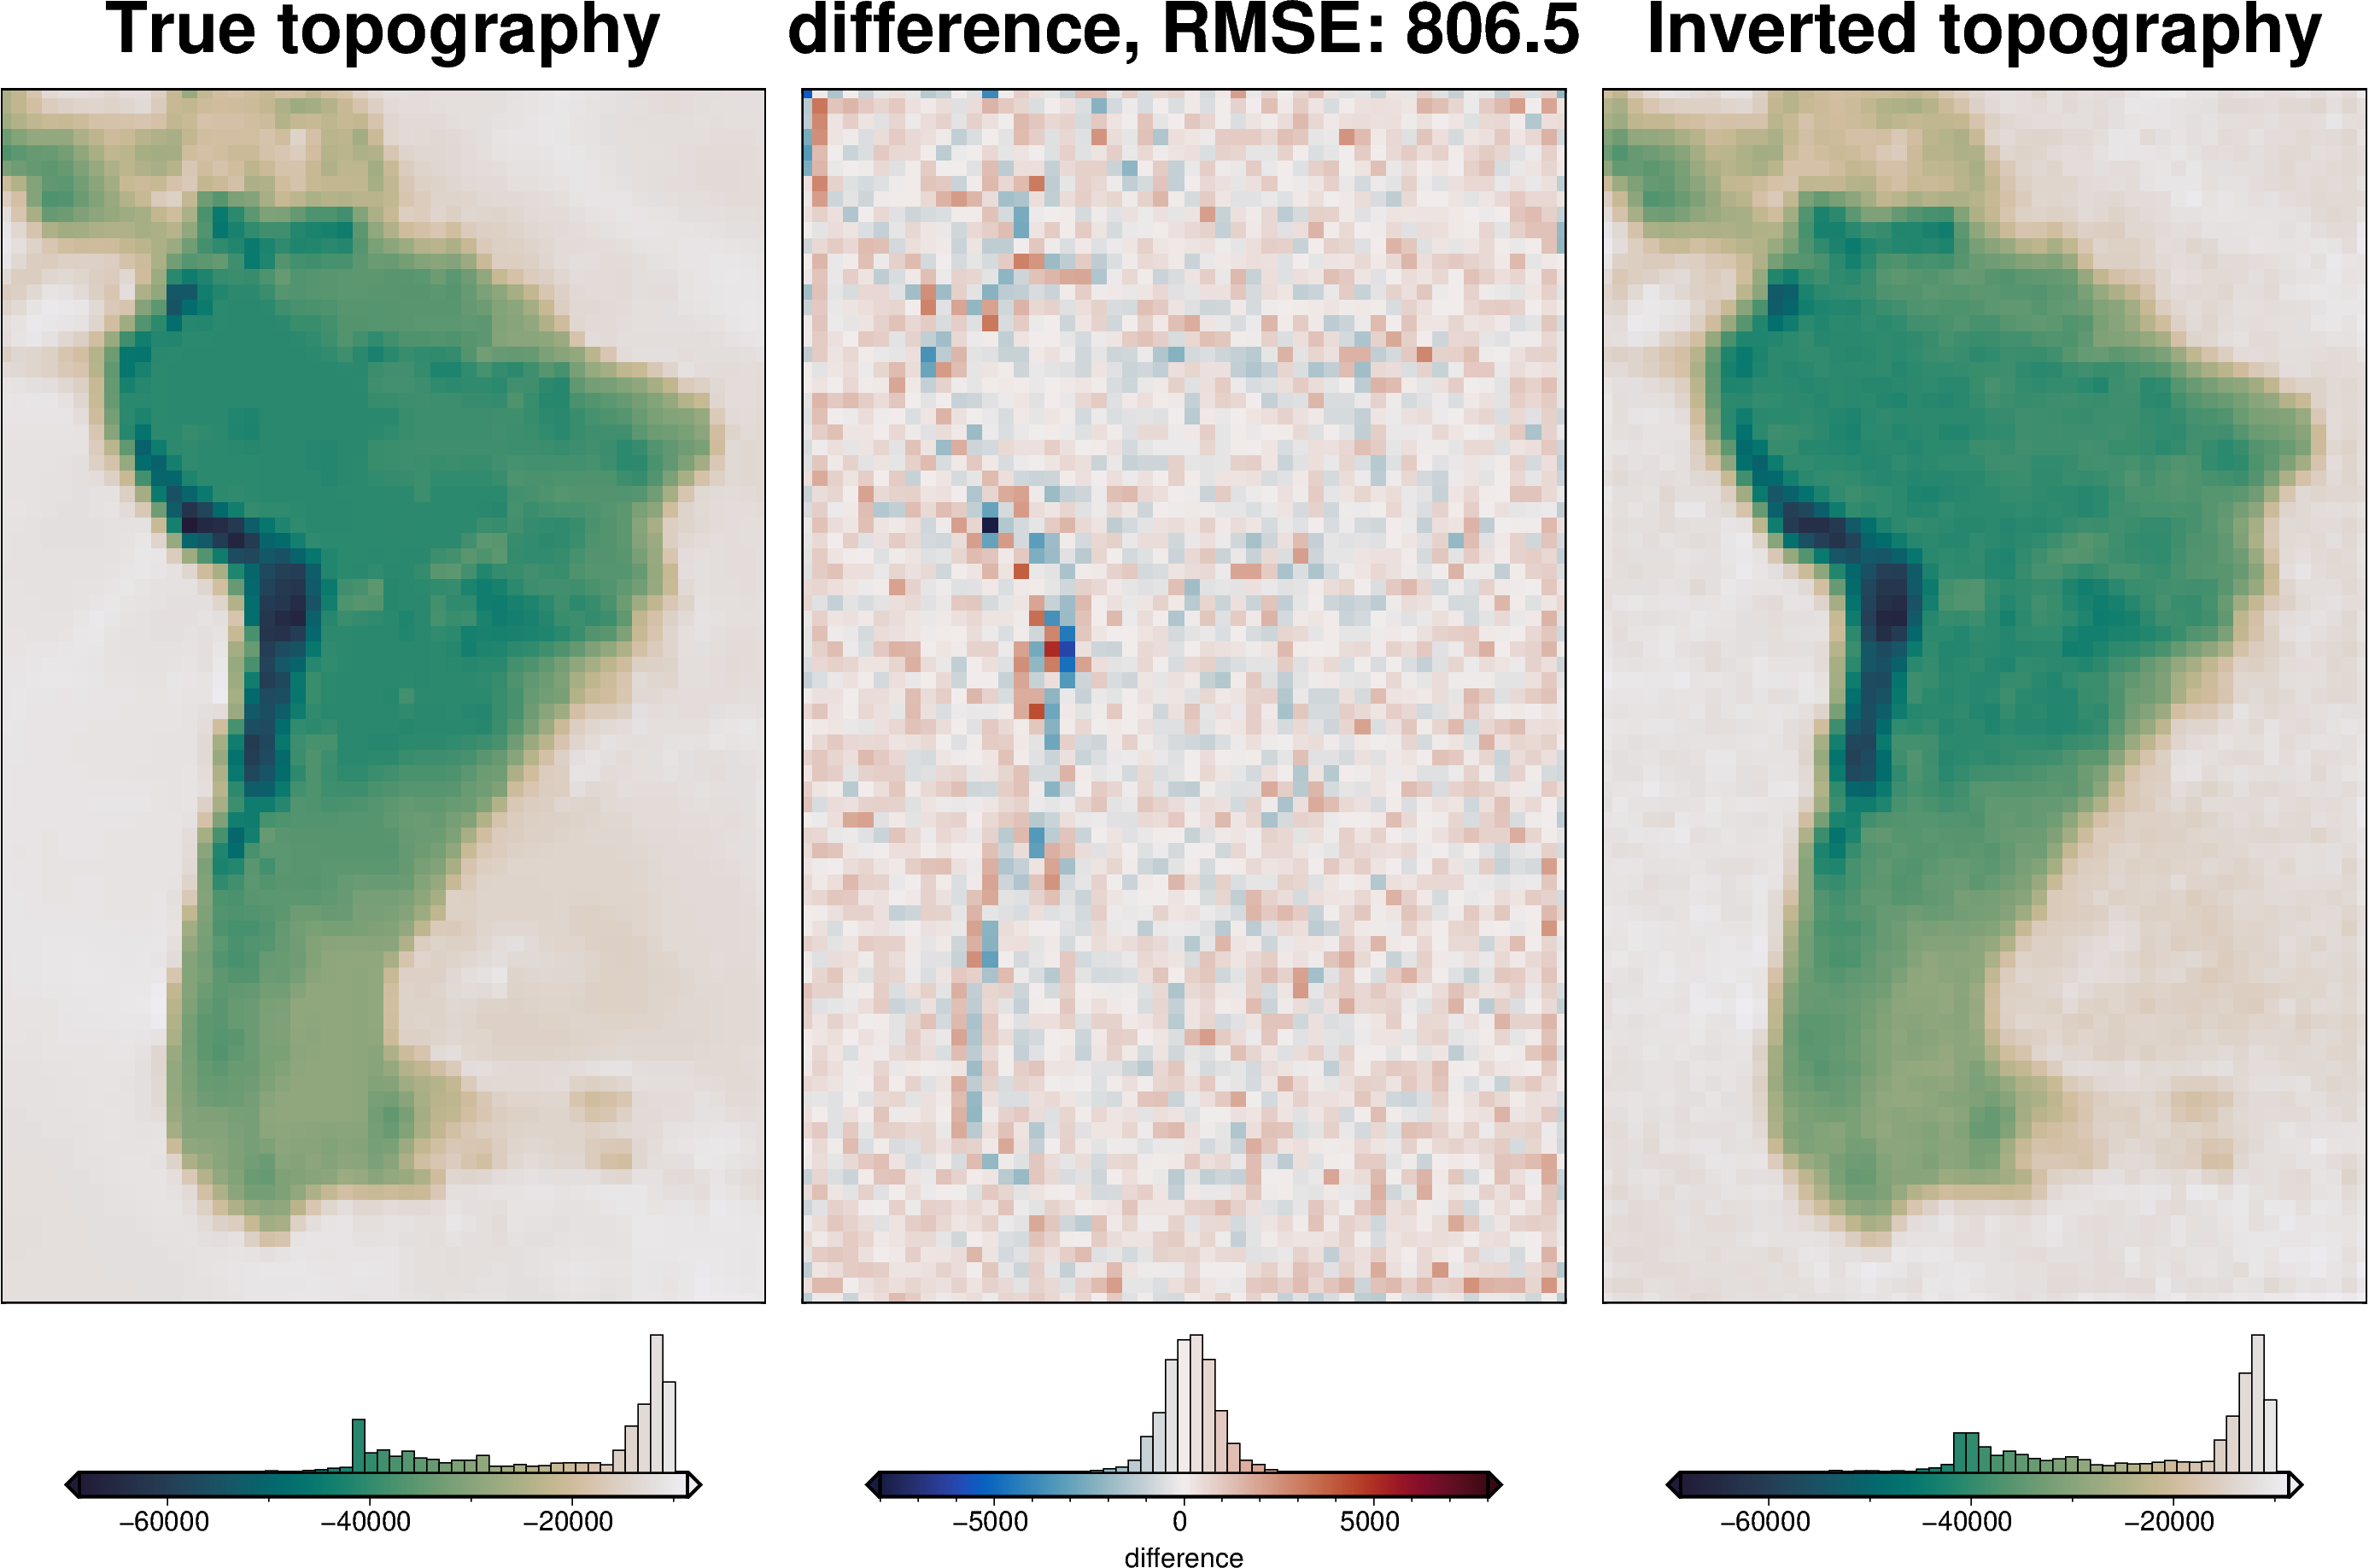

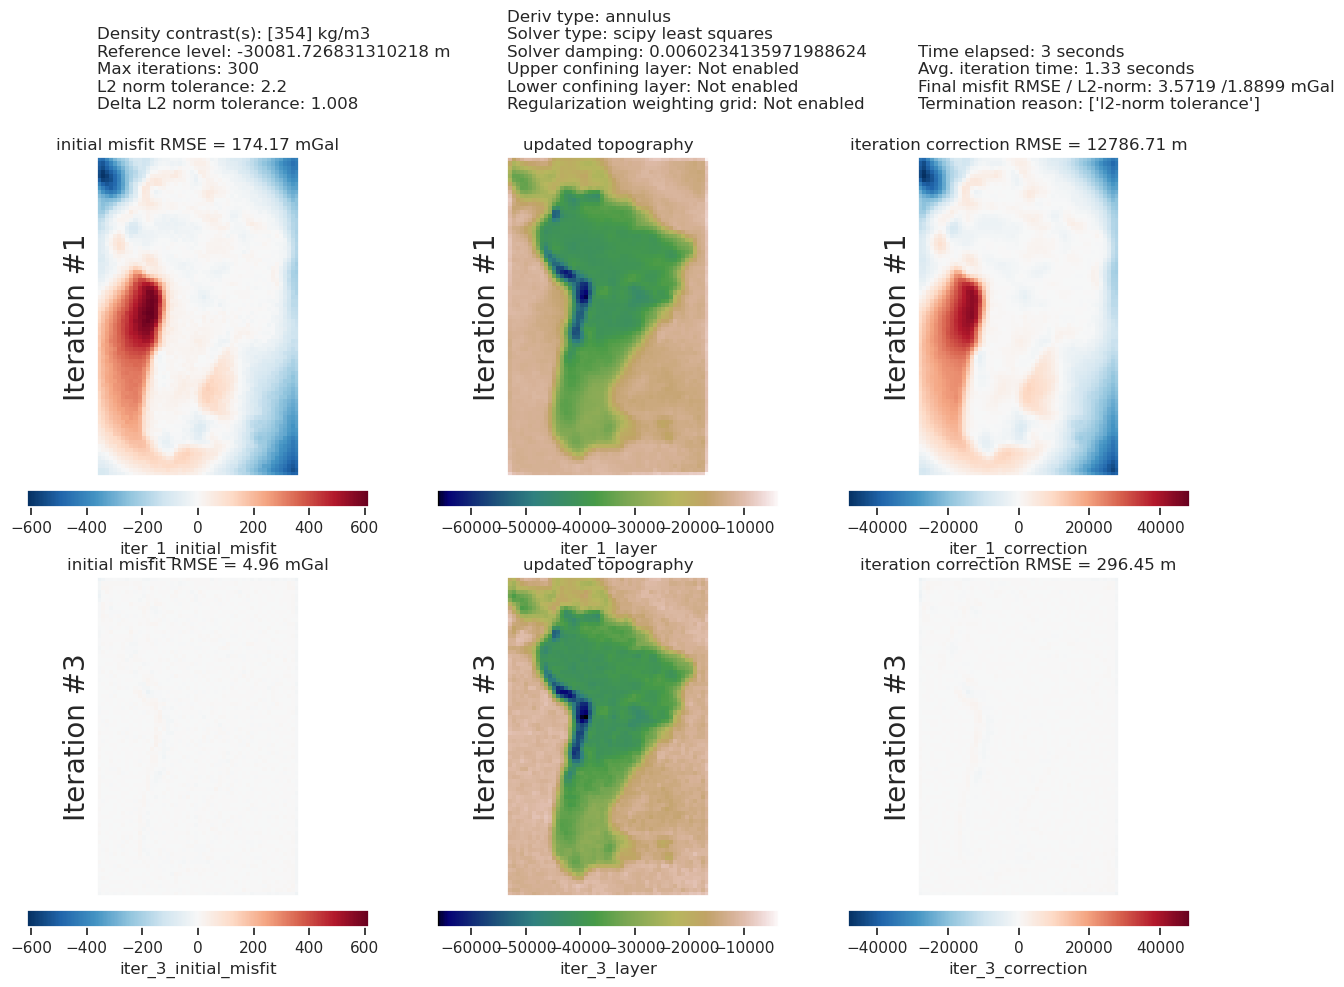

In [40]:
plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=False,
    plot_grav_results=False,
    fig_height=18,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    true_moho,
    final_topography,
    plot=True,
    region=region,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    # robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
)

In [41]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
)

rmse = utils.rmse(constraint_points.upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 569.40 m


The inversion error without a starting model was 900 m, and 1300 m at constraint points. Including a starting model reduced these both to 800 m and 570 m, respectively.

## Use a weighting grid
To ensure the inversion doesn't alter the starting model at the constraint points, where we know what the Moho elevation is, we can use a weighting grid. This scales each iterations correction values to be 0 at the constraint points. It's a good idea to redo the damping parameter CV when using this since the optimal damping value will likely change when you're usin a weighting grid.

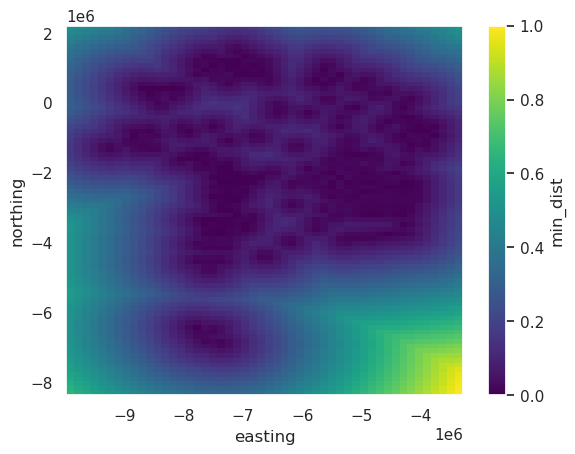

In [42]:
# calculate the distance between each grid cell and the nearest constraint, then
# normalize those values between 0 and 1
weighting_grid = utils.normalized_mindist(
    constraint_points,
    starting_prisms,
    low=0,
    high=1,
)
weighting_grid.plot()

INFO:invert4geom:saving all results with root name '../tmp/uieda_CRUST1_zref_density_cv_with_starting_model_weighted'
INFO:invert4geom:running damping cross validation
INFO:invert4geom:using 4 startup trials


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 7
INFO:invert4geom:	parameter: {'damping': 0.004839999906664827}
INFO:invert4geom:	scores: [4.436787971733774]
INFO:invert4geom:results saved to ../tmp/uieda_CRUST1_zref_density_cv_with_starting_model_weighted_results.pickle.pickle


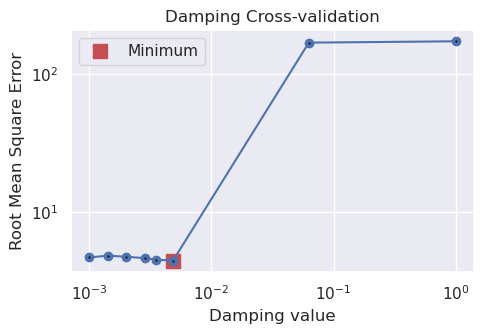

In [43]:
inversion_results = inversion.run_inversion_workflow(
    # enable the use of weights
    apply_weighting_grid=True,
    weighting_grid=weighting_grid,
    grav_df=grav_df,
    constraints_df=constraint_points,
    solver_damping=best_damping,
    create_starting_prisms=True,
    starting_topography=starting_topography,
    zref=best_zref,
    density_contrast=best_density_contrast,
    calculate_regional_misfit=True,
    regional_grav_kwargs={
        "method": "constant",
        "constant": 0,
    },
    run_damping_cv=True,
    damping_limits=(0.001, 1),
    damping_cv_trials=8,
    # need to provide spacing and region to resample the gravity data into test/train
    # sets
    grav_spacing=spacing,
    inversion_region=region,
    fname="../tmp/uieda_CRUST1_zref_density_cv_with_starting_model_weighted",
    plot_cv=True,
    **kwargs,
)

In [44]:
# to re-load the inversion results from the saved pickle file
name = "../tmp/uieda_CRUST1_zref_density_cv_with_starting_model_weighted_damping_cv_results.pickle"  # noqa: E501
with pathlib.Path(name).open("rb") as f:
    inversion_results = pickle.load(f)

# collect the results
topo_results, grav_results, parameters, elapsed_time = inversion_results

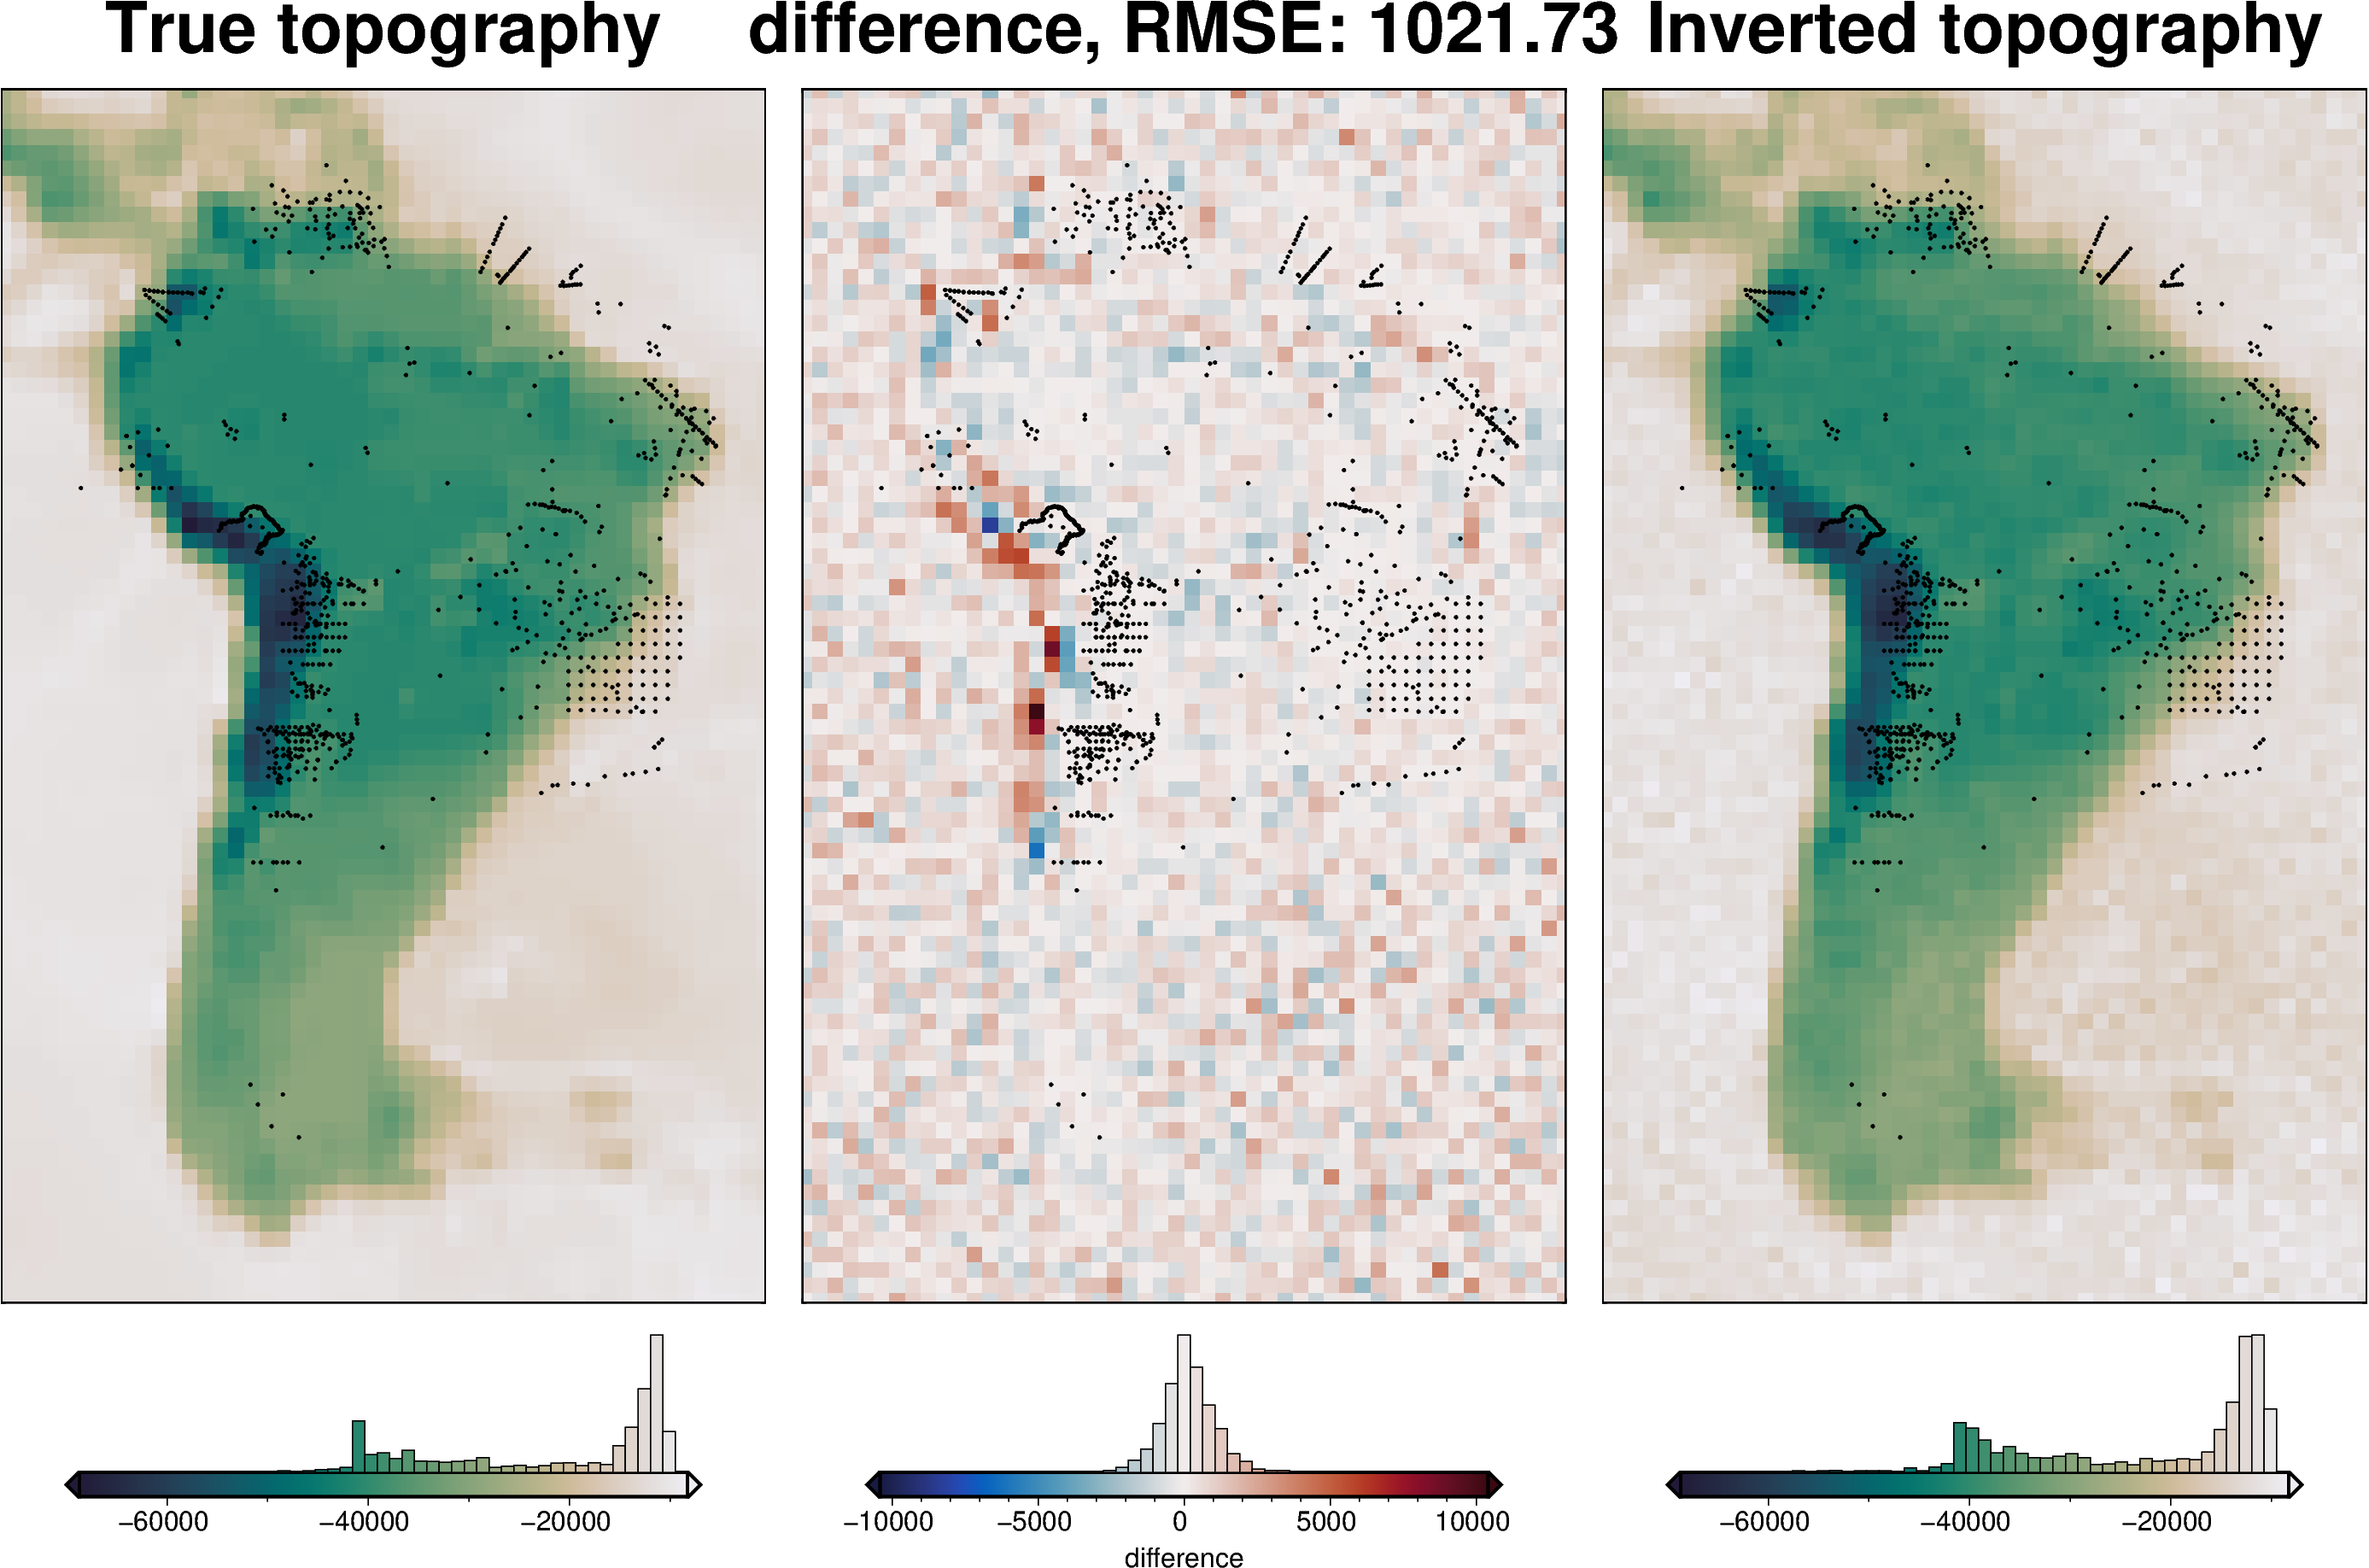

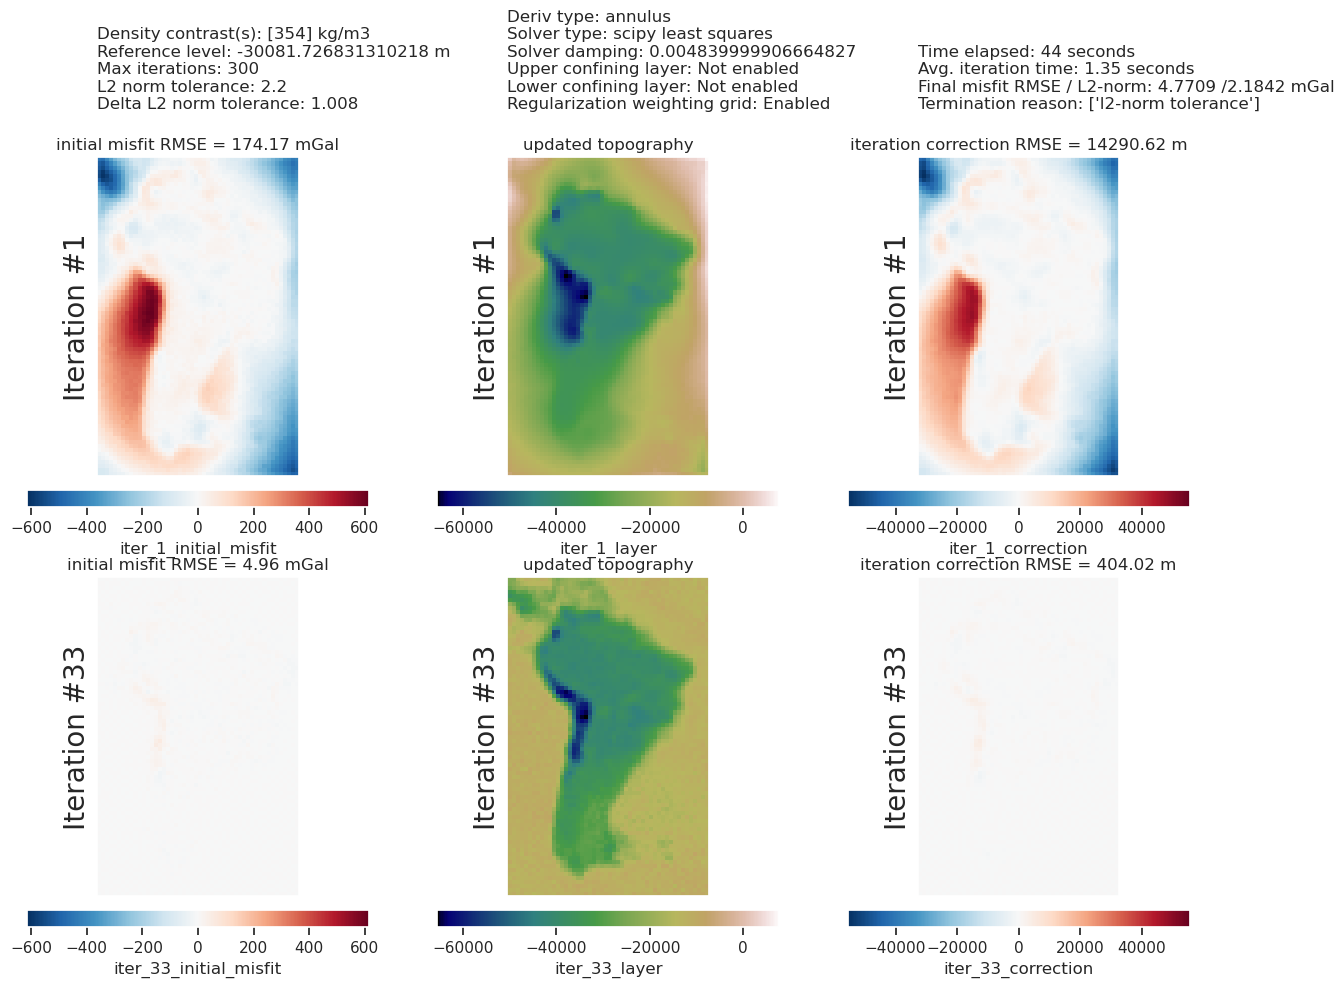

In [45]:
plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=False,
    plot_grav_results=False,
    fig_height=18,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    true_moho,
    final_topography,
    plot=True,
    region=region,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    # robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points,
    points_style="x.02c",
)

In [46]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
)

rmse = utils.rmse(constraint_points.upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 212.66 m


As you can see, adding the weight grid has helped adhere to the constraint points. The RMSE at constraints without the weighting grid was 1300 m and 570 m, without and with a starting model, respectively. Including the weighting grid lowered this to 210 m.

However, overall this inversion performed worse. The overall RMSE without the weighting grid was 900 m and 800 m, , without and with a starting model, respectively. Using the weighting grid inclreased this to 1020 m.